In [1]:
import semopy # SEM optimization in python
import pandas as pd
import numpy as np 
import os # for base_dir
from scipy import stats
import graphviz

from PIL import Image
from IPython.display import display

In [2]:
base_dir=os.getcwd()
if os.name == 'nt':
    path_break='\\'
else:
    path_break='/'

# Main function to find SEM for description of model

In [3]:
def run_SEM(data, description, name):
    model_SEM = semopy.Model(description)
    optimize_results = model_SEM.fit(data)
    #print(optimize_results)

    inspect_estimates = model_SEM.inspect(mode='list', what='names', std_est=True)
    inspect_df = pd.DataFrame(inspect_estimates)
    inspect_df.to_excel(f'{base_dir}{path_break}Estimates{path_break}inspect_estimates_{name}.xlsx')

    fit_stats = semopy.calc_stats(model_SEM)
    fit_stats_df = pd.DataFrame(fit_stats)
    fit_stats_df.to_excel(f'{base_dir}{path_break}Fit_Stats{path_break}fit_stats_{name}.xlsx')

    g = semopy.semplot(model_SEM, f'{base_dir}{path_break}Graphs{path_break}model_{name}.jpg', plot_covs=True)
    # In the future, remove p-values for less clutered graphs
    img = Image.open(f'{base_dir}{path_break}Graphs{path_break}model_{name}.jpg')
    display(img)

    fit_ideal_dict = {
    #    'chi2': '0',
    #    'chi2 p-value': '>0.05',
        'RMSEA': '<0.1',
        'CFI': '>0.9',
        'GFI': '>0.9',
        'TLI': '>0.95'
    }

    fit_actual_dict = {
    #    'chi2': fit_stats_df.at['Value', 'chi2'],
    #    'chi2 p-value': fit_stats_df.at['Value', 'chi2 p-value'],  
        'RMSEA': fit_stats_df.at['Value', 'RMSEA'],  
        'CFI': fit_stats_df.at['Value', 'CFI'],
        'GFI': fit_stats_df.at['Value', 'GFI'],
        'TLI': fit_stats_df.at['Value', 'TLI']
    }

    print(f'Model Name: {name}')
    for key in fit_ideal_dict.keys():
        print(f'Ideal {key} is {fit_ideal_dict[key]}, actual is {round(fit_actual_dict[key], 2)}')

    semopy.report(model_SEM, f'{base_dir}{path_break}Reports{path_break}model_{name}')

In [4]:
# extract estimates for linear regressions
def extract_estimates(name):
    estimates_df = pd.read_excel(name, index_col=0)
    coeff_estimates_df = estimates_df[estimates_df['lval'] != estimates_df['rval']].copy()
    err_estimates_df = estimates_df[estimates_df['lval'] == estimates_df['rval']].copy()
    err_estimates_df.set_index('lval', drop=True, inplace=True)
    return [coeff_estimates_df[['lval', 'rval', 'Estimate']], err_estimates_df[['Estimate']]]

# apply linear regressions to define latent values
def apply_estimates(data, coeff_df, err_df):
    repeat_at_end = [] # retry running these at end when other values have been defined
    for unique_latent in coeff_df['rval'].unique():
        reduced_df = coeff_df[coeff_df['rval'] == unique_latent].copy()
        reduced_df.set_index('lval', drop=False, inplace=True)
        not_defined = 0 # check that all variabls are available in data_df
        for variable in reduced_df['lval'].unique():
            if variable not in data.columns.values:
                not_defined = 1
        if not_defined == 1:
            repeat_at_end.append(unique_latent)
        else:
            for variable in reduced_df['lval'].unique():
                var_coeff = reduced_df.at[variable, 'Estimate']
                var_err = err_df.at[variable, 'Estimate']
                if unique_latent not in data.columns.values:
                    data[unique_latent] = var_coeff * data[variable] + var_err
                else:
                    data[unique_latent] += var_coeff * data[variable] + var_err

    while len(repeat_at_end) > 0:
        for repeat_latent in repeat_at_end:
            repeat_at_end.remove(repeat_latent) # remove it from the list
            reduced_df = coeff_df[coeff_df['rval'] == repeat_latent].copy()
            reduced_df.set_index('lval', drop=False, inplace=True)
            variable_missing = 0 
            for variable in reduced_df['lval'].unique():
                if variable in data.columns.values:
                    var_coeff = reduced_df.at[variable, 'Estimate']
                    var_err = err_df.at[variable, 'Estimate']
                    if repeat_latent not in data.columns.values:
                        data[repeat_latent] = var_coeff * data[variable] + var_err
                    else:
                        data[repeat_latent] += var_coeff * data[variable] + var_err
                else: 
                    variable_missing = 1
            if variable_missing == 1:
                repeat_at_end.append(repeat_latent)

# Separate call for data

In [5]:
# dicts to map string categories to numerical categories
dict_Q3 = {
    'Male': 0,
    'Female': 1
}
dict_Q4 = {
    '18 - 24 years old': 0,
    '25 - 34 years old': 1,
    '35 - 44 years old': 2,
    '45 - 54 years old': 3, 
    '55 - 64 years old': 4
}
dict_Q5 = {
    'Black or African American': 0,
    'Prefer not to say': 1, 
    'Hawaiian or Pacific Islander': 2, 
    'Asian': 3, 
    'White': 4, 
    'Hispanic, Latino, or Spanish': 5, 
    'Other': 6, 
    'Native American': 7, 
    'Indian': 8, 
    'Middle Eastern or North African': 9
}
dict_Q6 = {
    'No Response': 0,
    '2.0 - 2.49': 1,
    '2.5 - 2.99': 2,
    '3.0 - 3.49': 3,
    '3.5 - 4.0': 4
}
dict_Q7 = {
    'Undeclared': 0,
    'A.S. in Aeronautics': 1, 
    'A.S. in Aviation Business Administration': 2, 
    'A.S. in Aviation Maintenance': 3,
    'A.S. in Technical Management': 4,
    'B.S. in Aeronautics': 5, 
    'B.S. in Aviation Maintenance': 6,
    'B.S. in Unmanned Systems Applications': 7,
    'B.S. in Technical Management': 8, 
    'B.S. in Logistics and Supply Chain Management': 9,
    'B.S. in Project Management': 10,
    'B.S. in Aviation Business Administration': 11, 
    'B.S. in Interdisciplinary Studies': 12, 
    'B.S. in Safety Management': 13, 
    'B.S. in Business Analytics': 14, 
    'B.S. in Homeland Security': 15,
    'B.S. in Engineering': 16, 
    'B.S. in Emergency Services': 17,
    'Other': 18
}
dict_Q8 = {
    'No Response': 0,
    'Unemployed': 1,
    'Part time employment': 2,
    'Full time employment': 3,
    'Retired': 4
}

replace_dict = {
    'Q3': dict_Q3, 
    'Q4': dict_Q4, 
    'Q5': dict_Q5, 
    'Q6': dict_Q6, 
    'Q7': dict_Q7, 
    'Q8': dict_Q8
}

data = pd.read_excel('clean_data_final.xlsx', index_col=0)
data = data.replace(replace_dict)
# Normalize grade columns
data['Discussions Final Score'] = stats.zscore(data['Discussions Final Score'], nan_policy='omit')
data['Final Score'] = stats.zscore(data['Final Score'], nan_policy='omit')

#pre_data = data[data['PRE or POST'] == 'PRE'].copy()
#pre_data = pre_data.replace(replace_dict)

#post_data = data[data['PRE or POST'] == 'POST'].copy()
#post_data = post_data.replace(replace_dict)

# Define initial col names
teaching_presence_cols = ['Q17_1', 'Q17_2', 'Q17_3', 'Q17_4', 'Q18_1', 'Q18_2', 'Q18_3', 'Q18_4', 'Q18_5', 'Q19_1', 'Q19_2', 'Q19_3']
social_presence_cols = ['Q19_4', 'Q19_5', 'Q20_1', 'Q20_2', 'Q20_3', 'Q20_4', 'Q20_5', 'Q21_1', 'Q21_2']
cognitive_presence_cols = ['Q21_3', 'Q21_4', 'Q21_5', 'Q22_1', 'Q22_2', 'Q22_3', 'Q22_4', 'Q22_5', 'Q23_1', 'Q23_2', 'Q23_3', 'Q23_4']
grade_cols = ['Discussions Final Score', 'Final Score']
understanding_expectations = ['Q24_1', 'Q24_2', 'Q24_3', 'Q24_4']
initial_post = ['Q25_1', 'Q25_2', 'Q25_3', 'Q25_4']
reading_posts = ['Q26_1', 'Q26_2', 'Q26_3', 'Q26_4']
replying_to_posts = ['Q27_1', 'Q27_2', 'Q27_3', 'Q27_4']
integrate_feedback = ['Q28_1', 'Q28_2', 'Q28_3', 'Q28_4']
demographic_cols = ['Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Create conversion dicts for col names
grade_dict = {
    'Discussions Final Score': 'Discussion_Score',
    'Final Score': 'Total_Course_Score'
}

demographic_dict = {
    'Q3': 'gender', 
    'Q4': 'age_group', 
    'Q5': 'ethnicity', 
    'Q6': 'gpa_group', 
    'Q7': 'major', 
    'Q8': 'employment_group'
}

teaching_presence_dict = {}
for index in range(1, len(teaching_presence_cols)+2): # our list is missing a question
    if index < 5: # our survey accidentally missed question 5
        teaching_presence_dict[teaching_presence_cols[index-1]] = f'TP_{index}'
    elif index > 5:
        teaching_presence_dict[teaching_presence_cols[index-2]] = f'TP_{index}' # map TP_6 to 5th element of teaching_presence_cols

social_presence_dict = {}
for index in range(1, len(social_presence_cols)+1):
    social_presence_dict[social_presence_cols[index-1]] = f'SP_{index}'

cognitive_presence_dict = {}
for index in range(1, len(cognitive_presence_cols)+1):
    cognitive_presence_dict[cognitive_presence_cols[index-1]] = f'CP_{index}'

understanding_expectations_dict = {}
for index in range(1, len(understanding_expectations)+1):
    understanding_expectations_dict[understanding_expectations[index-1]] = f'CL_UE_{index}'

initial_post_dict = {}
for index in range(1, len(initial_post)+1):
    initial_post_dict[initial_post[index-1]] = f'CL_IP_{index}'

reading_posts_dict = {}
for index in range(1, len(reading_posts)+1):
    reading_posts_dict[reading_posts[index-1]] = f'CL_RP_{index}'

replying_to_posts_dict = {}
for index in range(1, len(replying_to_posts)+1):
    replying_to_posts_dict[replying_to_posts[index-1]] = f'CL_RtP_{index}'

integrate_feedback_dict = {}
for index in range(1, len(integrate_feedback)+1):
    integrate_feedback_dict[integrate_feedback[index-1]] = f'CL_IF_{index}'

for dict in [teaching_presence_dict, social_presence_dict, cognitive_presence_dict, understanding_expectations_dict, initial_post_dict, reading_posts_dict, replying_to_posts_dict, integrate_feedback_dict, grade_dict, demographic_dict]:
    data.rename(dict, axis='columns', inplace=True)
#    pre_data.rename(dict, axis='columns', inplace=True)
#    post_data.rename(dict, axis='columns', inplace=True)

# Create new lists of col names
new_grade_cols = ['Discussion_Score', 'Total_Course_Score']
new_demographic_cols = ['gender', 'age_group', 'ethnicity', 'gpa_group', 'major', 'employment_group']
new_tp_cols = []
for index in range(1, len(teaching_presence_cols)+2):
    if index != 5:
        new_tp_cols.append(f'TP_{index}')
new_sp_cols = [f'SP_{index}' for index in range(1, len(social_presence_cols)+1)]
new_cp_cols = [f'CP_{index}' for index in range(1, len(cognitive_presence_cols)+1)]
new_cl_ue_cols = [f'CL_UE_{index}' for index in range(1, len(understanding_expectations)+1)]
new_cl_ip_cols = [f'CL_IP_{index}' for index in range(1, len(initial_post)+1)]
new_cl_rp_cols = [f'CL_RP_{index}' for index in range(1, len(reading_posts)+1)]
new_cl_rtp_cols = [f'CL_RtP_{index}' for index in range(1, len(replying_to_posts)+1)]
new_cl_if_cols = [f'CL_IF_{index}' for index in range(1, len(integrate_feedback)+1)]

In [6]:
data[new_tp_cols].describe()

TP_1        TP_2        TP_3        TP_4        TP_6        TP_7   
count  277.000000  278.000000  278.000000  277.000000  278.000000  278.000000  \
mean     2.902527    2.953237    2.946043    3.090253    4.032374    4.003597   
std      1.560806    1.587851    1.587622    1.703304    1.131608    1.175865   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      1.000000    1.000000    1.000000    1.000000    4.000000    4.000000   
50%      3.000000    3.000000    3.000000    3.000000    4.000000    4.000000   
75%      4.000000    4.000000    4.750000    5.000000    5.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

             TP_8        TP_9       TP_10       TP_11       TP_12       TP_13  
count  278.000000  277.000000  277.000000  275.000000  278.000000  278.000000  
mean     3.992806    4.075812    3.916968    4.127273    4.079137    4.140288  
std      1.146310    1.147474    1.143809    1.011874    1.124488    1.077383  
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000  
25%      3.000000    4.000000    3.000000    4.000000    4.000000    4.000000  
50%      4.000000    4.000000    4.000000    4.000000    4.000000    4.000000  
75%      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000  
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000

# Descriptive model based on literature paper

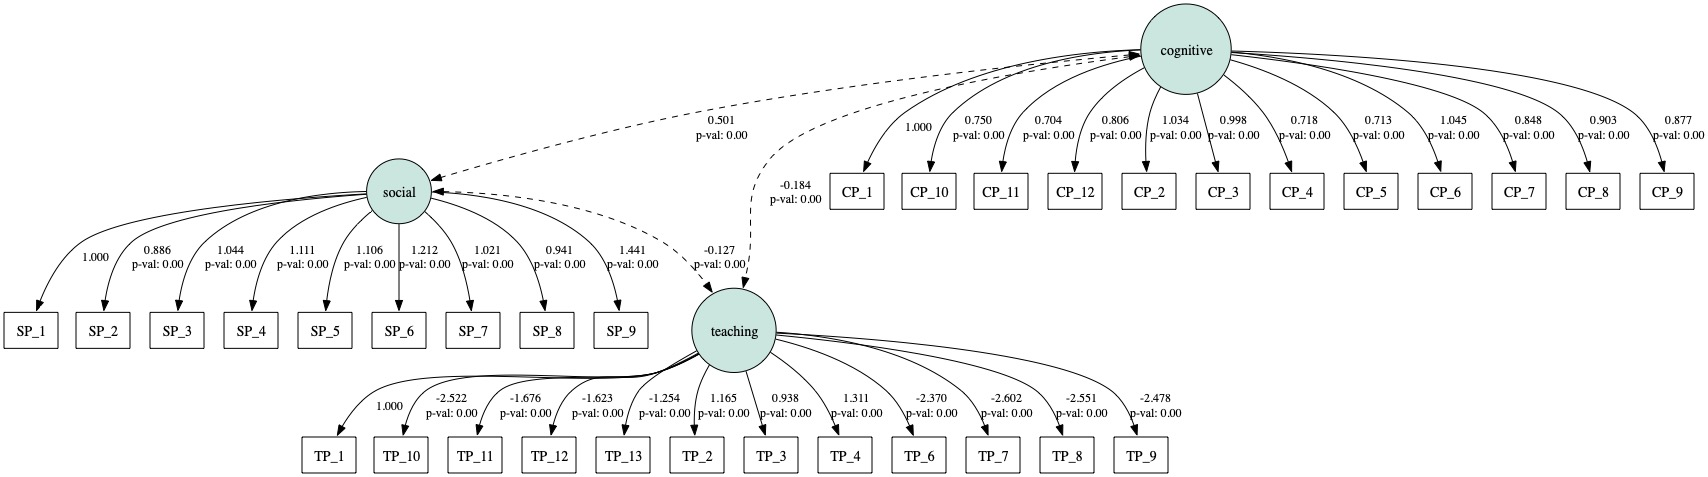

Model Name: Presence_Literature
Ideal RMSEA is <0.1, actual is 0.15
Ideal CFI is >0.9, actual is 0.67
Ideal GFI is >0.9, actual is 0.64
Ideal TLI is >0.95, actual is 0.64


In [7]:
latent_teaching_lit = 'teaching =~ TP_1 + TP_2 + TP_3 + TP_4 + TP_6 + TP_7 + TP_8 + TP_9 + TP_10 + TP_11 + TP_12 + TP_13'
latent_social_lit = 'social =~ SP_1 + SP_2 + SP_3 + SP_4 + SP_5 + SP_6 + SP_7 + SP_8 + SP_9'
latent_cognitive_lit = 'cognitive =~  CP_1 + CP_2 + CP_3 + CP_4 + CP_5 + CP_6 + CP_7 + CP_8 + CP_9 + CP_10 + CP_11 + CP_12'
latent_relations_presence = '''
teaching ~~ social
teaching ~~ cognitive
social ~~ cognitive
'''
description_presence_lit = f'{latent_teaching_lit}\n{latent_social_lit}\n{latent_cognitive_lit}\n{latent_relations_presence}'
run_SEM(data, description_presence_lit, 'Presence_Literature')

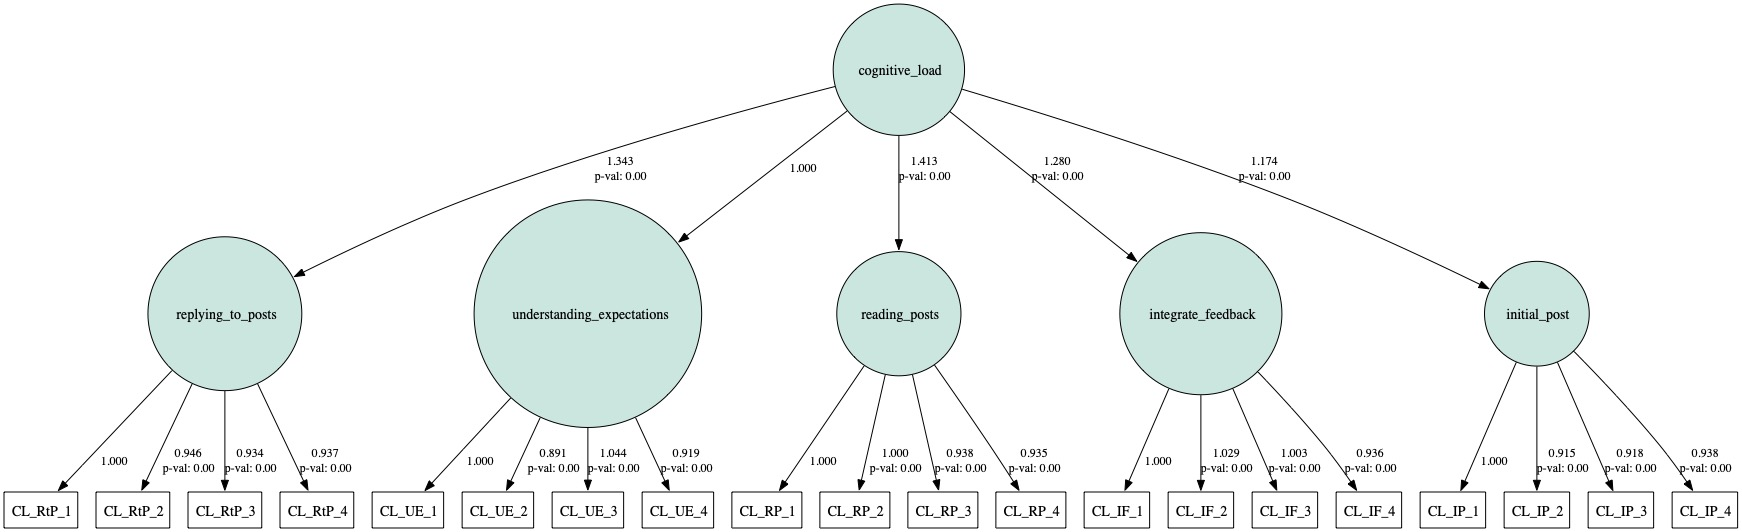

Model Name: Cognitive_Load_Literature
Ideal RMSEA is <0.1, actual is 0.13
Ideal CFI is >0.9, actual is 0.86
Ideal GFI is >0.9, actual is 0.84
Ideal TLI is >0.95, actual is 0.84


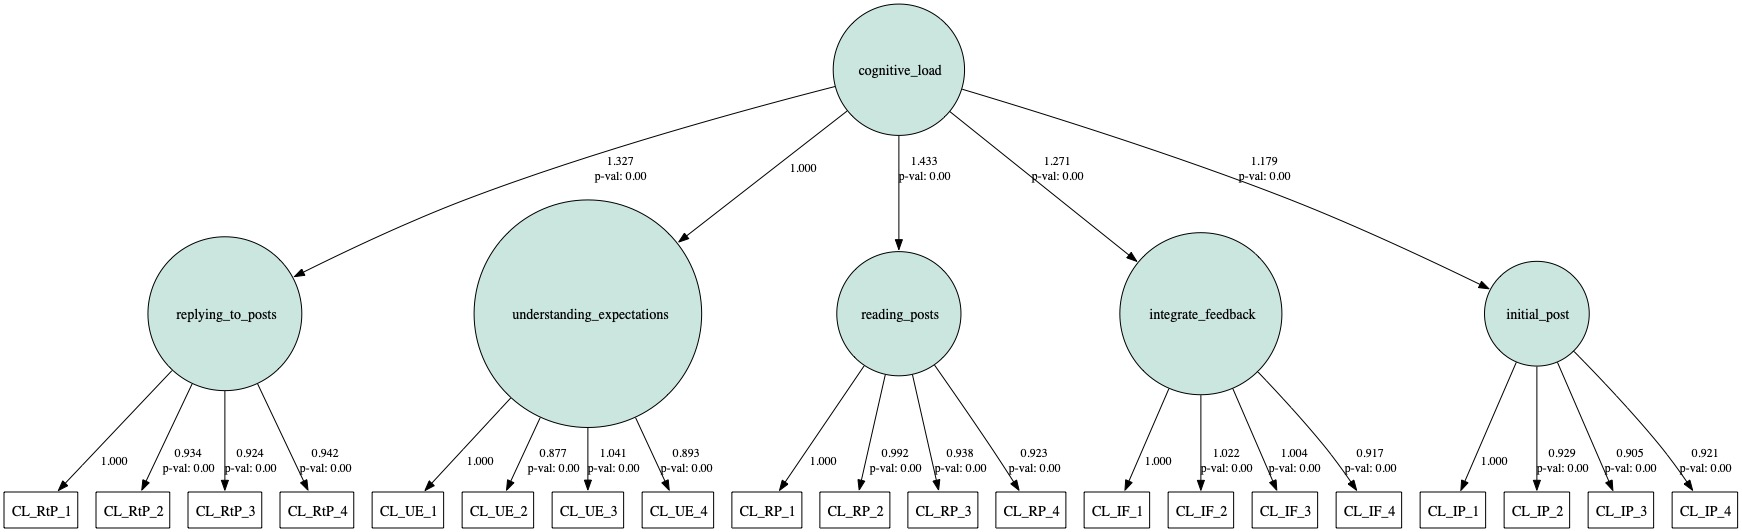

Model Name: Cognitive_Load_Literature_dropna
Ideal RMSEA is <0.1, actual is 0.13
Ideal CFI is >0.9, actual is 0.86
Ideal GFI is >0.9, actual is 0.83
Ideal TLI is >0.95, actual is 0.84


In [8]:
description_cog_load_lit = '''
understanding_expectations =~ CL_UE_1 + CL_UE_2 + CL_UE_3 + CL_UE_4
initial_post =~ CL_IP_1 + CL_IP_2 + CL_IP_3 + CL_IP_4
reading_posts =~ CL_RP_1 + CL_RP_2 + CL_RP_3 + CL_RP_4
replying_to_posts =~ CL_RtP_1 + CL_RtP_2 + CL_RtP_3 + CL_RtP_4
integrate_feedback =~ CL_IF_1 + CL_IF_2 + CL_IF_3 + CL_IF_4
cognitive_load =~ understanding_expectations + initial_post + reading_posts + replying_to_posts + integrate_feedback
'''
run_SEM(data, description_cog_load_lit, 'Cognitive_Load_Literature')
# Try dropping data to see if it improve model
data.dropna(how='any', inplace=True)
run_SEM(data, description_cog_load_lit, 'Cognitive_Load_Literature_dropna')

# Confirmatory Factor Analysis to improve models

In [9]:
teaching_data = data[new_tp_cols].copy()
teaching_data.dropna(how='any', inplace=True)
print(semopy.efa.explore_cfa_model(teaching_data))

eta1 =~ TP_2 + TP_1 + TP_3 + TP_4
eta2 =~ TP_7 + TP_10 + TP_8 + TP_9 + TP_6 + TP_11 + TP_12 + TP_13



In [10]:
social_data = data[new_sp_cols].copy()
social_data.dropna(how='any', inplace=True)
print(semopy.efa.explore_cfa_model(social_data))

eta1 =~ SP_6 + SP_5 + SP_7 + SP_4
eta2 =~ SP_1 + SP_2
eta3 =~ SP_4 + SP_3
eta4 =~ SP_9 + SP_8



In [11]:
cognitive_data = data[new_cp_cols].copy()
cognitive_data.dropna(how='any', inplace=True)
print(semopy.efa.explore_cfa_model(cognitive_data))

eta1 =~ CP_2 + CP_3 + CP_1
eta2 =~ CP_10 + CP_11 + CP_9 + CP_12
eta3 =~ CP_8 + CP_7 + CP_6 + CP_9 + CP_5 + CP_4



## New EFA-based descriptive models

In [12]:
all_presence_data = data[new_tp_cols+new_sp_cols+new_cp_cols].copy()
all_presence_data.dropna(how='any', inplace=True)
print(semopy.efa.explore_cfa_model(all_presence_data))

eta1 =~ SP_6 + SP_5 + SP_9 + SP_7 + SP_8 + SP_4
eta2 =~ TP_2 + TP_1 + TP_3 + TP_4
eta3 =~ TP_8 + TP_10 + TP_7 + TP_9 + TP_6 + TP_11
eta4 =~ SP_4 + SP_3 + SP_9
eta5 =~ SP_1 + SP_2
eta6 =~ TP_12 + TP_11 + TP_13 + TP_4
eta7 =~ CP_2 + CP_8 + CP_7 + CP_3 + CP_1 + CP_4 + SP_8
eta8 =~ CP_8 + CP_10 + CP_11 + CP_9 + CP_12 + TP_11
eta9 =~ CP_8 + CP_6 + CP_7 + CP_9 + SP_9



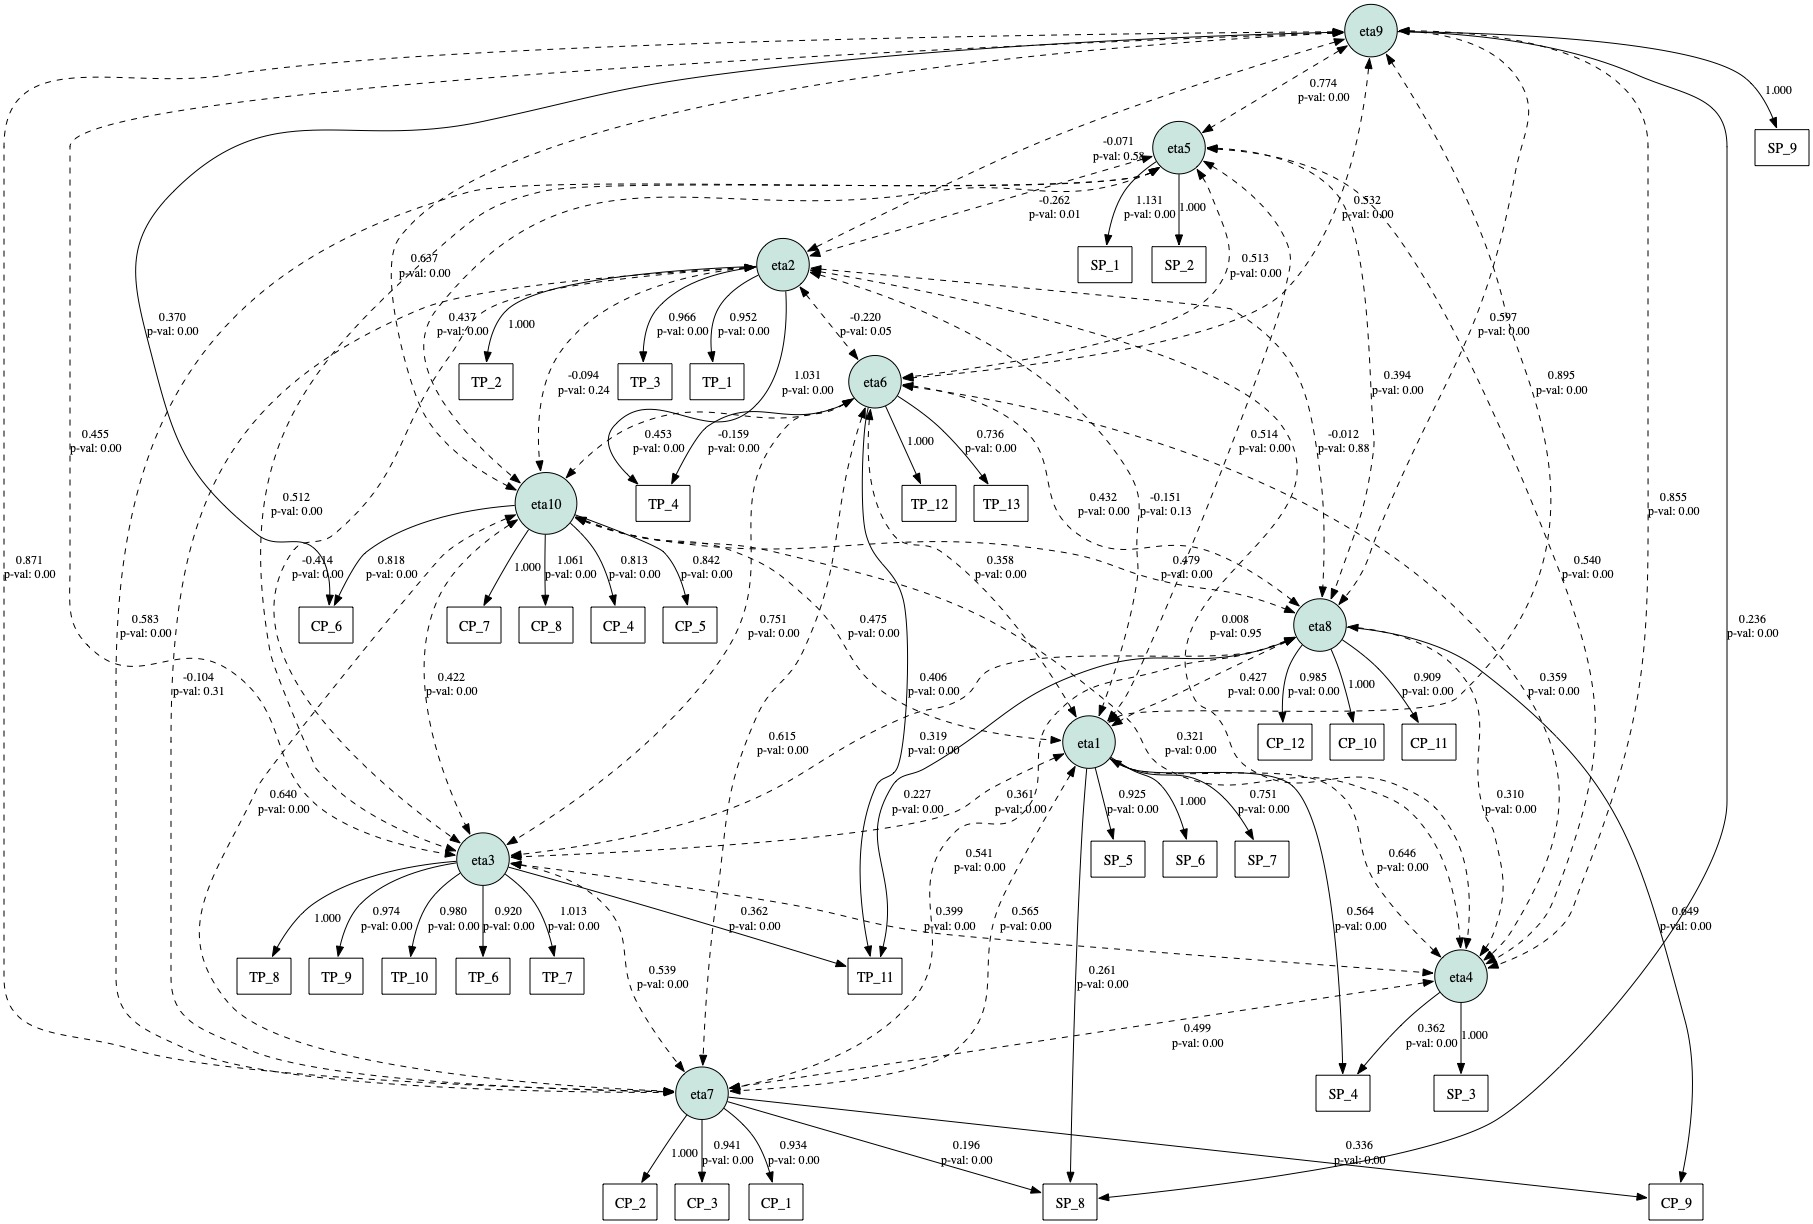

Model Name: Best_Presence_CFA
Ideal RMSEA is <0.1, actual is 0.07
Ideal CFI is >0.9, actual is 0.94
Ideal GFI is >0.9, actual is 0.89
Ideal TLI is >0.95, actual is 0.93


In [13]:
model_best_efa = '''
eta1 =~ SP_6 + SP_5 + SP_7 + SP_8 + SP_4
eta2 =~ TP_2 + TP_1 + TP_3 + TP_4
eta3 =~ TP_8 + TP_10 + TP_7 + TP_9 + TP_6 + TP_11
eta4 =~ SP_3 + SP_4
eta5 =~ SP_2 + SP_1
eta6 =~ TP_12 + TP_11 + TP_13 + TP_4
eta7 =~ CP_2 + CP_1 + CP_3 + CP_9 + SP_8
eta8 =~ CP_10 + CP_11 + CP_12 + CP_9 + TP_11
eta9 =~ SP_9 + CP_6 + SP_8
eta10 =~ CP_7 + CP_8 + CP_6 + CP_4 + CP_5
'''

run_SEM(data, model_best_efa, 'Best_Presence_CFA')

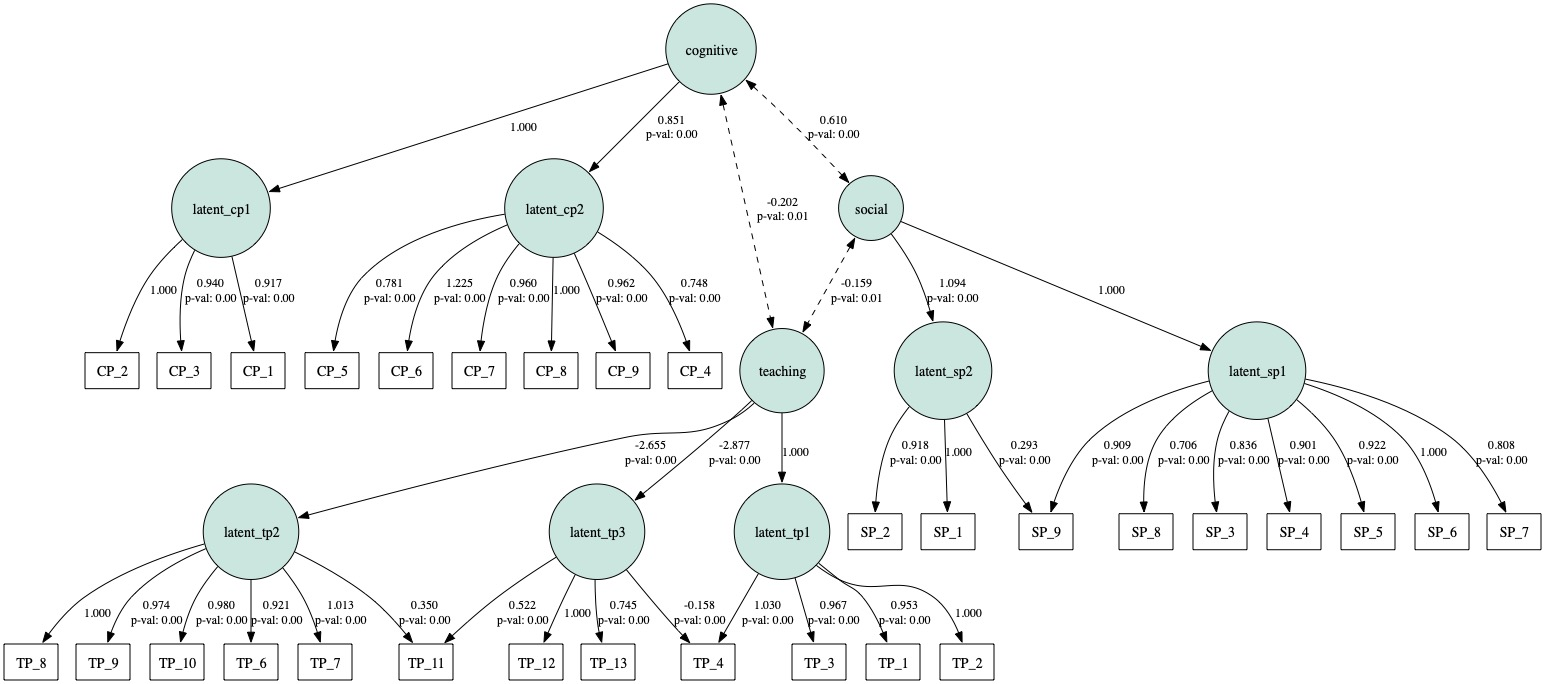

Model Name: Presence_CFA
Ideal RMSEA is <0.1, actual is 0.08
Ideal CFI is >0.9, actual is 0.92
Ideal GFI is >0.9, actual is 0.88
Ideal TLI is >0.95, actual is 0.91


In [14]:
latent_teaching_efa = '''
latent_tp1 =~ TP_2 + TP_3 + TP_4 + TP_1
latent_tp2 =~ TP_8 + TP_10 + TP_7 + TP_9 + TP_6 + TP_11
latent_tp3 =~ TP_12 + TP_11 + TP_13 + TP_4
teaching =~ latent_tp1 + latent_tp2 + latent_tp3
'''

latent_social_efa = '''
latent_sp1 =~ SP_6 + SP_5 + SP_9 + SP_4 + SP_7 + SP_8 + SP_3
latent_sp2 =~ SP_1 + SP_2 + SP_9
social =~ latent_sp1 + latent_sp2
'''

latent_cognitive_efa = '''
latent_cp1 =~ CP_2 + CP_3 + CP_1
latent_cp2 =~ CP_8 + CP_7 + CP_6 + CP_9 + CP_5 + CP_4
cognitive =~ latent_cp1 + latent_cp2
'''

latent_relations_presence = '''
teaching ~~ social
teaching ~~ cognitive
social ~~ cognitive
'''

description_presence_efa = f'{latent_teaching_efa}\n{latent_social_efa}\n{latent_cognitive_efa}\n{latent_relations_presence}'
run_SEM(data, description_presence_efa, 'Presence_CFA')

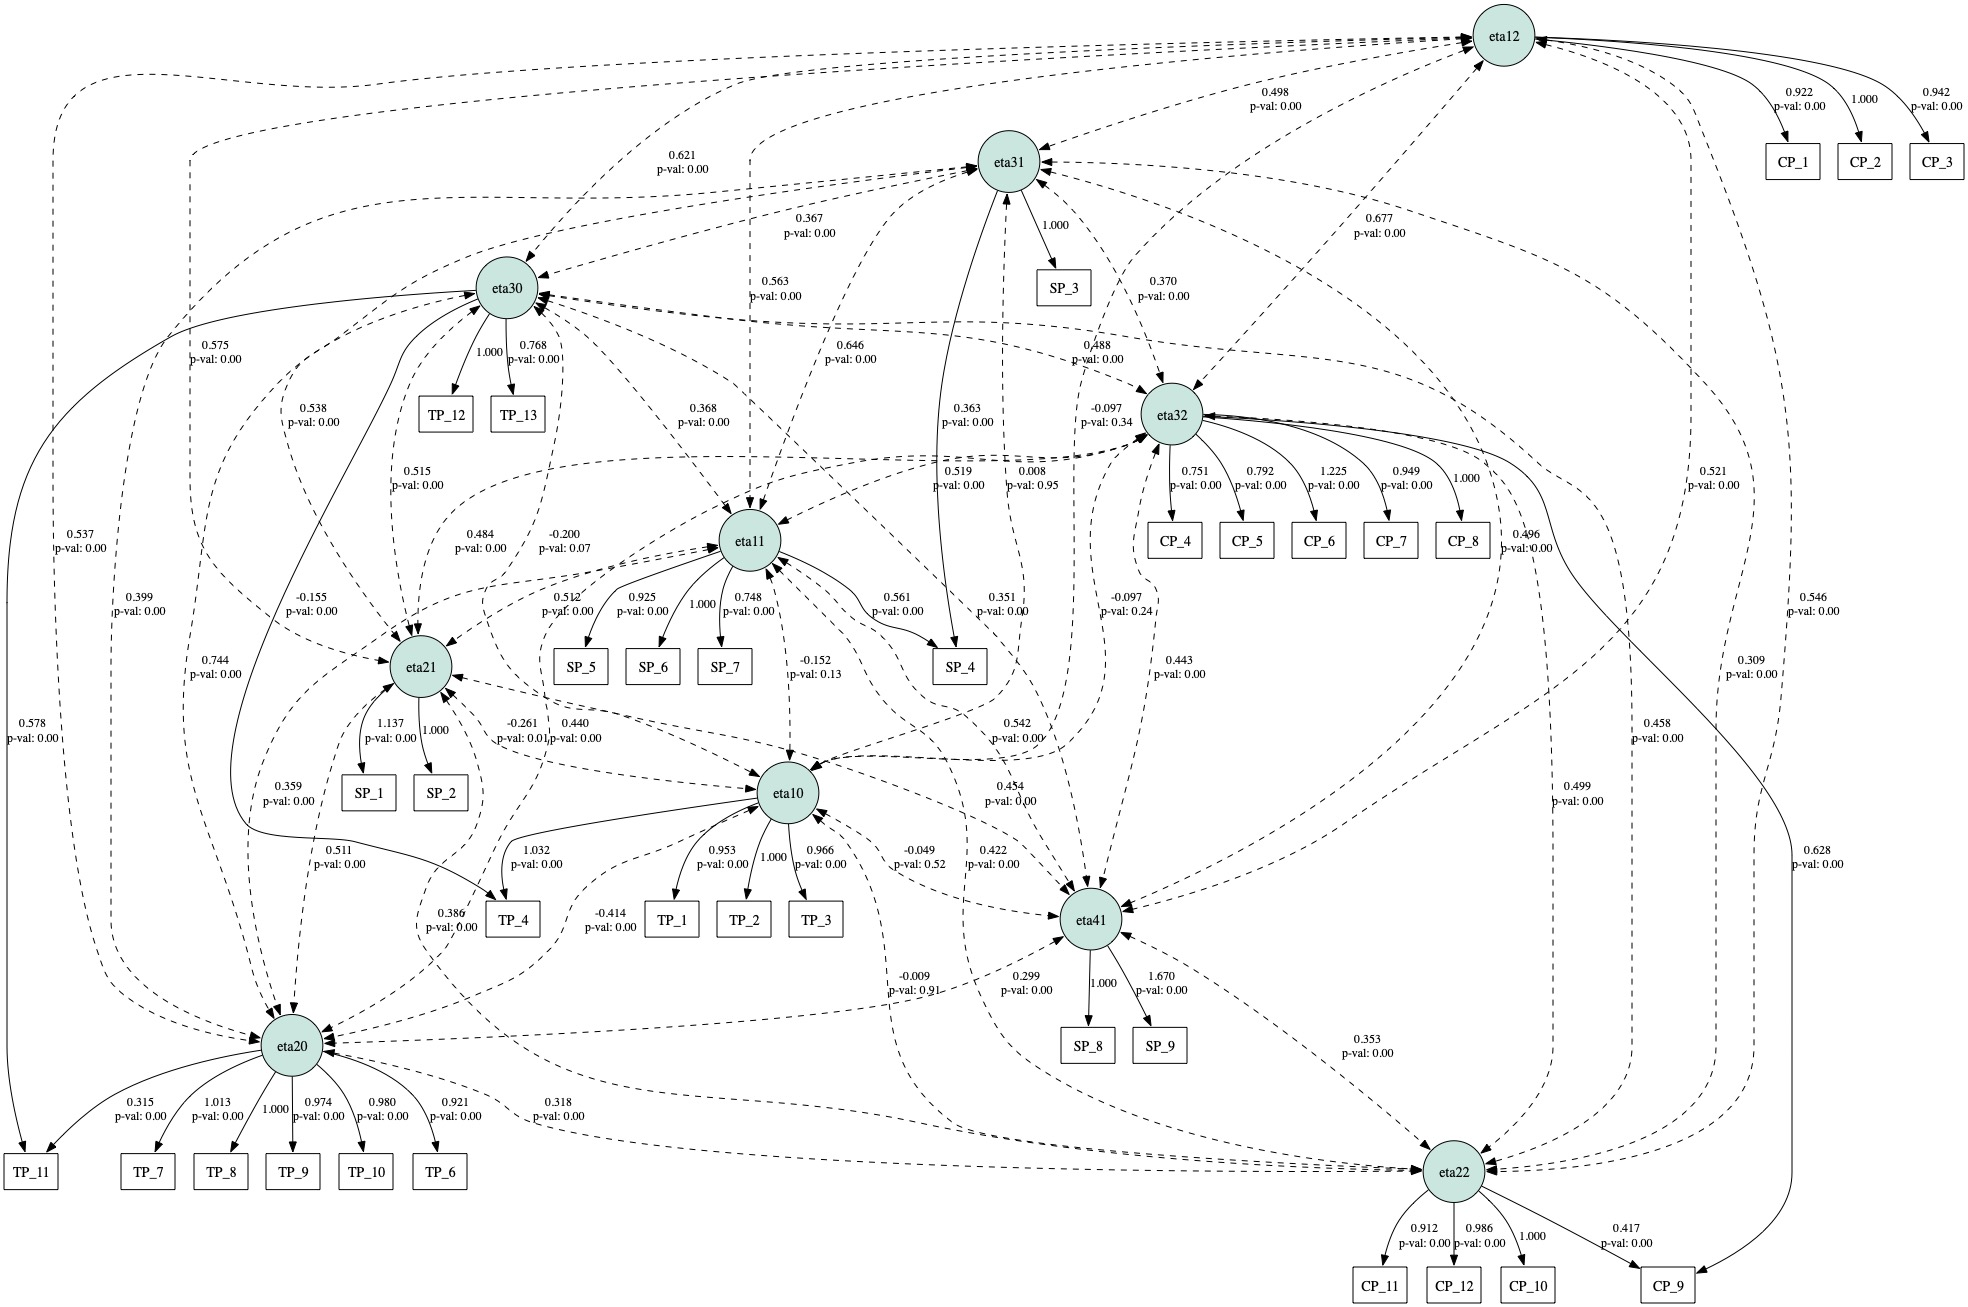

Model Name: Newer_Presence_CFA
Ideal RMSEA is <0.1, actual is 0.07
Ideal CFI is >0.9, actual is 0.93
Ideal GFI is >0.9, actual is 0.89
Ideal TLI is >0.95, actual is 0.92


In [15]:
newer_cfa_presence_model = '''
eta10 =~ TP_2 + TP_1 + TP_3 + TP_4
eta20 =~ TP_8 + TP_10 + TP_7 + TP_9 + TP_6 + TP_11
eta30 =~ TP_12 + TP_11 + TP_13 + TP_4

eta11 =~ SP_6 + SP_5 + SP_7 + SP_4
eta21 =~ SP_2 + SP_1
eta31 =~ SP_3 + SP_4
eta41 =~ SP_8 + SP_9

eta12 =~ CP_2 + CP_3 + CP_1
eta22 =~ CP_10 + CP_11 + CP_9 + CP_12
eta32 =~ CP_8 + CP_7 + CP_6 + CP_9 + CP_5 + CP_4
'''

run_SEM(data, newer_cfa_presence_model, 'Newer_Presence_CFA')

## CFA only minor improvements to Cognitive Load model

In [16]:
cognitive_load_data = data[new_cl_ue_cols+new_cl_ip_cols+new_cl_rp_cols+new_cl_rtp_cols+new_cl_if_cols].copy()
cognitive_load_data.dropna(how='any', inplace=True)
print(semopy.efa.explore_cfa_model(cognitive_load_data))

eta1 =~ CL_RtP_1 + CL_RtP_3 + CL_RtP_2 + CL_RtP_4
eta2 =~ CL_UE_3 + CL_UE_1 + CL_UE_2 + CL_UE_4
eta3 =~ CL_IF_2 + CL_IF_1 + CL_IF_3 + CL_IF_4
eta4 =~ CL_RP_2 + CL_RP_3 + CL_RP_1 + CL_RP_4 + CL_RtP_2
eta5 =~ CL_IP_1 + CL_IP_4 + CL_IP_2 + CL_IP_3



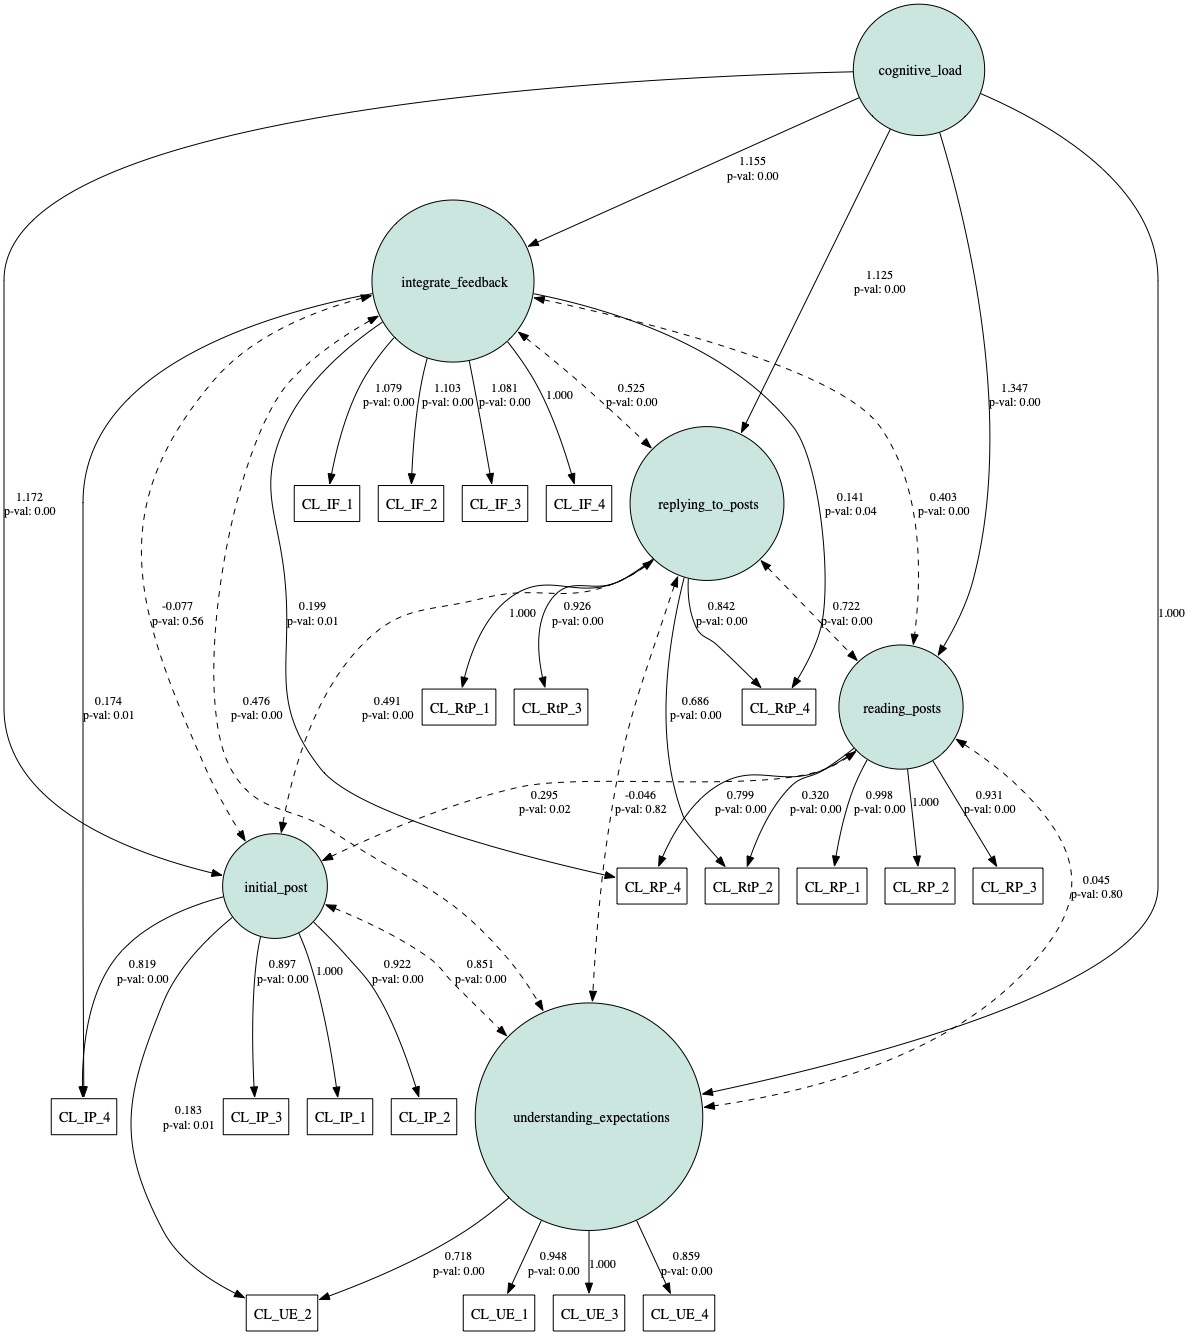

Model Name: Cognitive_Load_CFA
Ideal RMSEA is <0.1, actual is 0.13
Ideal CFI is >0.9, actual is 0.87
Ideal GFI is >0.9, actual is 0.85
Ideal TLI is >0.95, actual is 0.84


In [17]:
latent_cognitive_load_efa = '''
replying_to_posts =~ CL_RtP_1 + CL_RtP_3 + CL_RtP_2 + CL_RtP_4
understanding_expectations =~ CL_UE_3 + CL_UE_1 + CL_UE_2 + CL_UE_4
integrate_feedback =~ CL_IF_4 + CL_IF_2 + CL_IF_1 + CL_IF_3 + CL_RP_4 + CL_RtP_4 + CL_IP_4
reading_posts =~ CL_RP_2 + CL_RP_3 + CL_RP_1 + CL_RP_4 + CL_RtP_2
initial_post =~ CL_IP_1 + CL_IP_4 + CL_IP_2 + CL_IP_3 + CL_UE_2
cognitive_load =~ understanding_expectations + initial_post + reading_posts + replying_to_posts + integrate_feedback

understanding_expectations ~~ initial_post
understanding_expectations ~~ reading_posts
understanding_expectations ~~ replying_to_posts
understanding_expectations ~~ integrate_feedback
initial_post ~~ reading_posts
initial_post ~~ integrate_feedback
initial_post ~~ replying_to_posts
reading_posts ~~ replying_to_posts
reading_posts ~~ integrate_feedback
replying_to_posts ~~ integrate_feedback
'''
description_cog_load_efa = latent_cognitive_load_efa
run_SEM(data, description_cog_load_efa, 'Cognitive_Load_CFA')


In [18]:
#cog_load_g = graphviz.Digraph('cog_load', filename='cog_load.png')
#cog_load_g.edge('understanding_expectations', 'initial_post', style='dashed', label='0.944')
#cog_load_g.view()

with open(f'{base_dir}{path_break}Graphs{path_break}model_Cognitive_Load_CFA_covar') as f:
    dot_graph = f.read()

# remove the display(...)

cog_graph_final = graphviz.Source(dot_graph)
cog_graph_final.render(filename=f'{base_dir}{path_break}Graphs{path_break}model_Cognitive_Load_CFA_covar.jpg')

'/Users/darryl_chamberlain/Documents/git-repos/CoI_Python_Database_Analysis/Indirect_Measures/Analyze_Data/Graphs/model_Cognitive_Load_CFA_covar.jpg.pdf'

In [19]:
cognitive_load_data = data[new_cl_ue_cols+new_cl_ip_cols+new_cl_rp_cols+new_cl_rtp_cols+new_cl_if_cols+new_demographic_cols].copy()
cognitive_load_data.dropna(how='any', inplace=True)
print(semopy.efa.explore_cfa_model(cognitive_load_data))

eta1 =~ CL_RtP_1 + CL_RtP_3 + CL_RtP_2 + CL_RtP_4
eta2 =~ CL_UE_3 + CL_UE_1 + CL_UE_2 + CL_UE_4
eta4 =~ CL_IF_2 + CL_IF_1 + CL_IF_3 + CL_IF_4
eta5 =~ CL_RP_2 + CL_RP_3 + CL_RP_1 + CL_RP_4 + CL_RtP_2
eta6 =~ CL_IP_1 + CL_IP_4 + CL_IP_2 + CL_IP_3



In [20]:
cognitive_load_data = data[new_cl_ue_cols+new_cl_ip_cols+new_cl_rp_cols+new_cl_rtp_cols+new_cl_if_cols+new_demographic_cols+new_tp_cols+new_sp_cols+new_cp_cols].copy()
cognitive_load_data.dropna(how='any', inplace=True)
print(semopy.efa.explore_cfa_model(cognitive_load_data))

eta1 =~ CL_RtP_1 + CL_RtP_2 + CL_RtP_3 + CL_RtP_4
eta2 =~ CP_8 + CP_2 + CP_7 + CP_3 + CP_9 + CP_1 + CP_6 + SP_9 + CP_12 + CP_11 + CP_10 + SP_8 + CP_4 + CP_5 + TP_11 + SP_1 + SP_2 + TP_12 + TP_13 + CL_RtP_1
eta3 =~ CL_UE_3 + CL_UE_4 + CL_RP_3
eta4 =~ TP_2 + TP_1 + TP_3 + TP_4
eta6 =~ CL_IF_2 + CL_IF_1 + CL_IF_3
eta7 =~ CL_RP_2 + CL_RP_1 + CL_RP_3 + CL_RP_4 + CL_RtP_2
eta8 =~ CL_IP_1 + CL_IP_3 + CL_IP_2 + CL_IP_4
eta9 =~ CL_RP_4 + CL_RtP_4
eta10 =~ TP_10 + TP_7 + TP_8 + TP_9 + TP_6 + TP_11 + TP_12 + TP_13 + SP_1 + CL_UE_4
eta11 =~ CL_RtP_2 + CL_IP_2 + CL_RP_2 + CL_UE_2 + CL_RtP_3 + SP_2 + SP_1
eta13 =~ CL_UE_2 + CL_UE_1
eta14 =~ SP_6 + SP_9 + SP_5 + SP_4 + SP_8 + SP_7 + CP_6 + SP_1 + SP_3
eta15 =~ CL_IP_4 + CL_UE_4 + CL_RP_2 + CL_IF_3



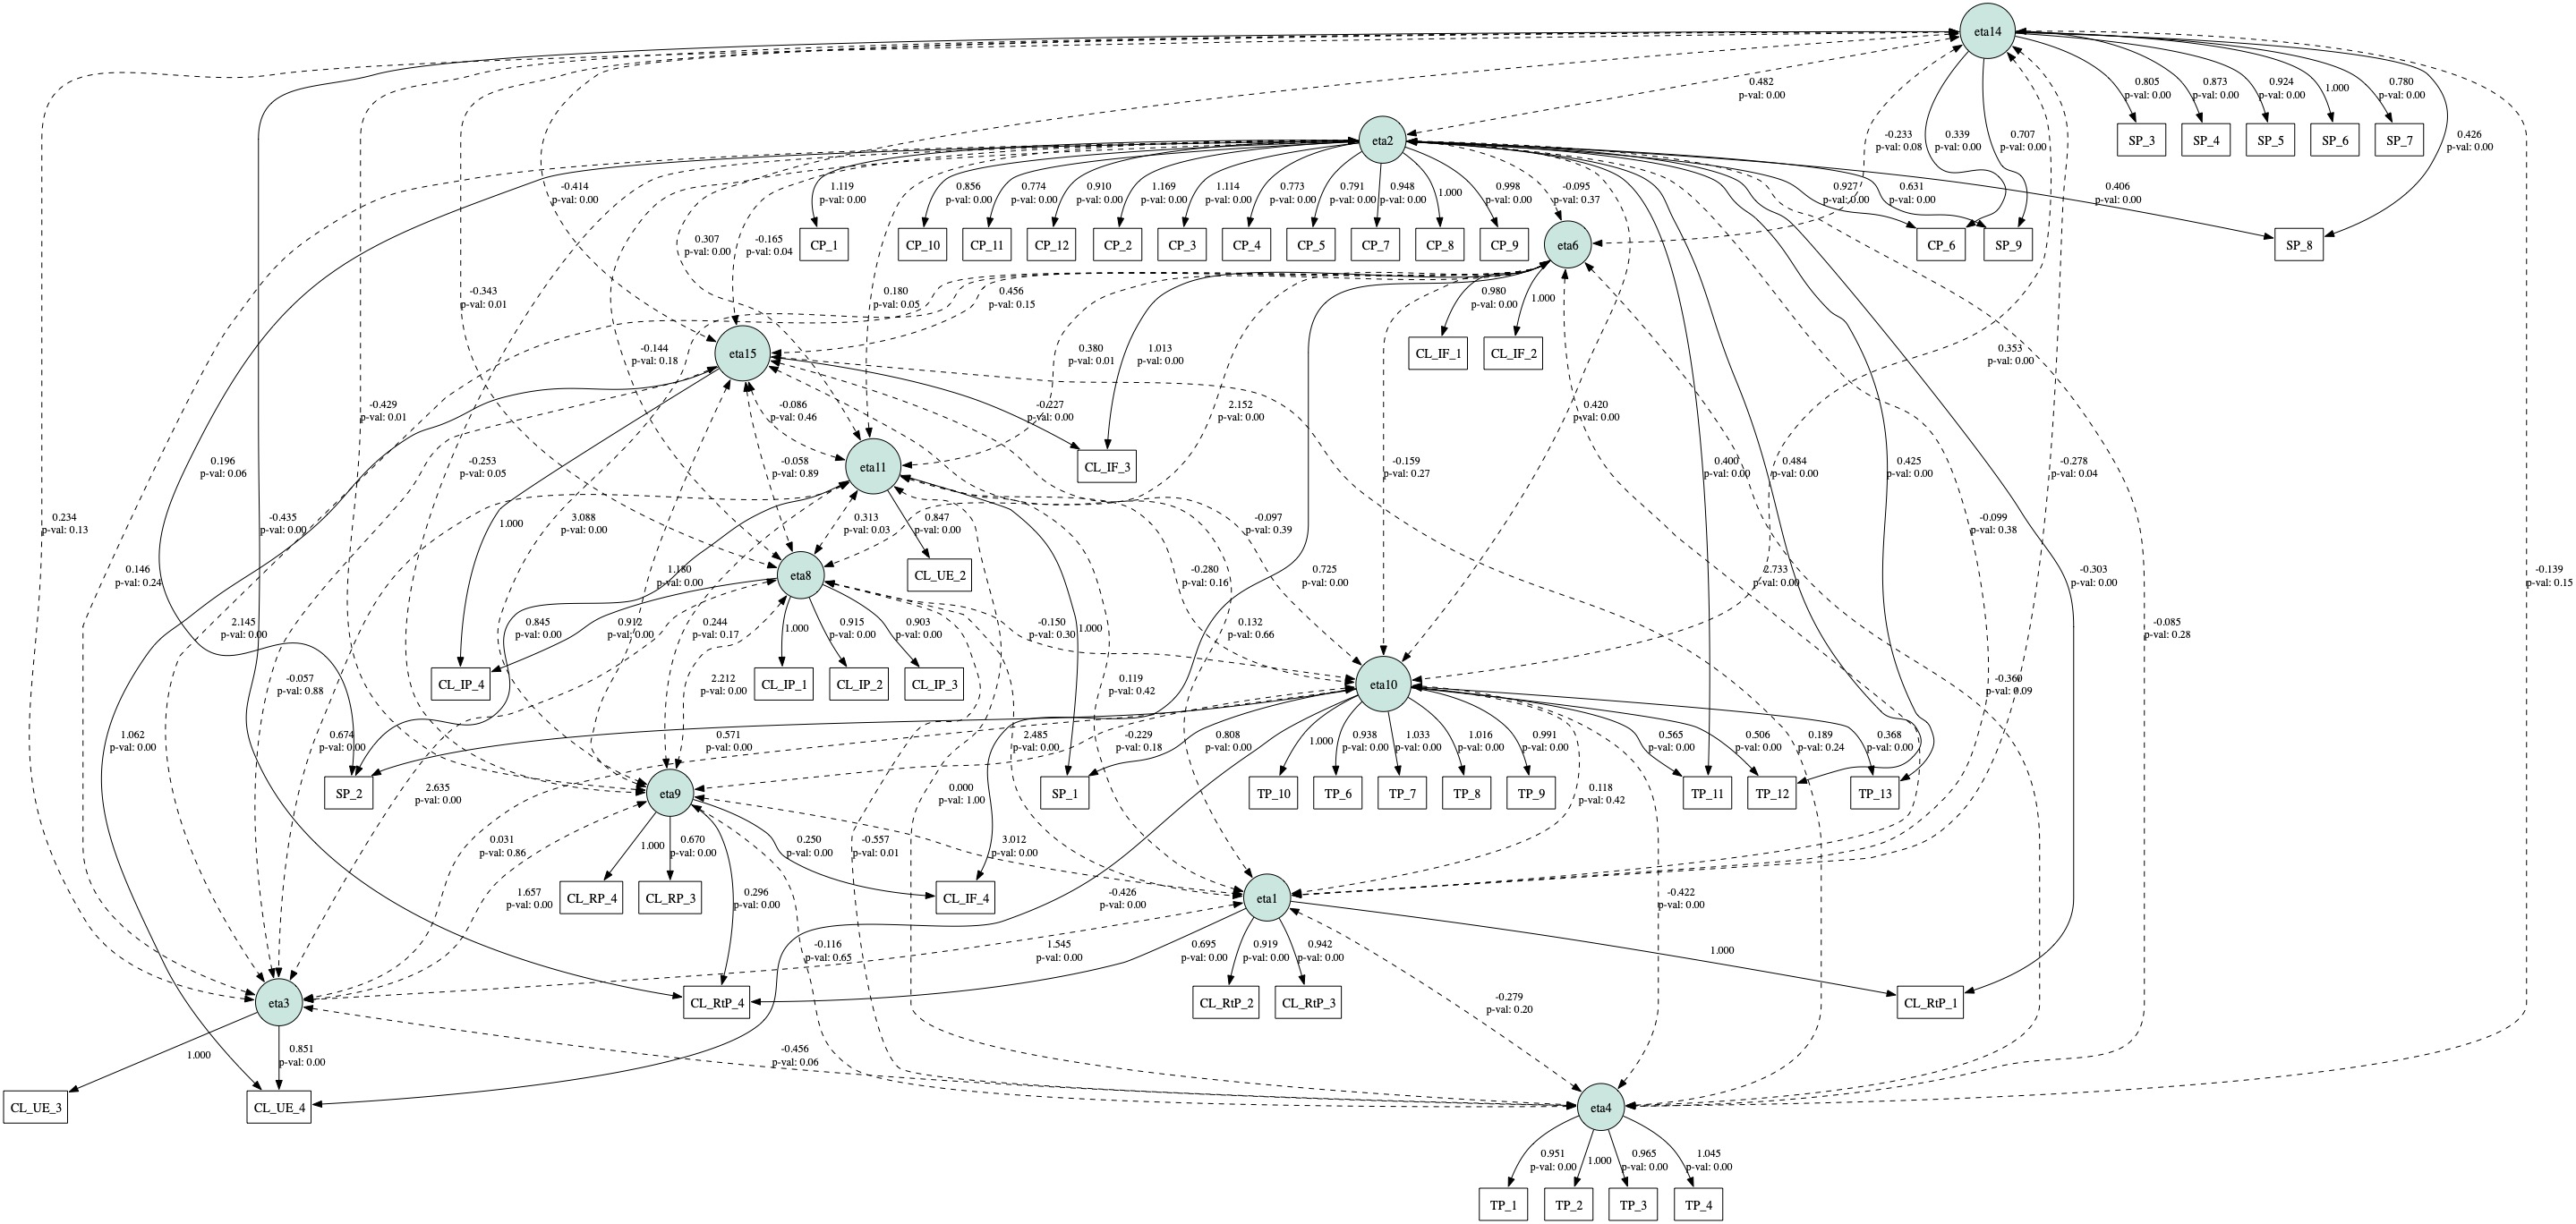

Model Name: Mixed Model
Ideal RMSEA is <0.1, actual is 0.08
Ideal CFI is >0.9, actual is 0.87
Ideal GFI is >0.9, actual is 0.8
Ideal TLI is >0.95, actual is 0.85


In [21]:
new_latent_model = '''
eta1 =~ CL_RtP_1 + CL_RtP_2 + CL_RtP_3 + CL_RtP_4
eta2 =~ CP_8 + CP_2 + CP_7 + CP_3 + CP_9 + CP_1 + CP_6 + SP_9 + CP_12 + CP_11 + CP_10 + SP_8 + CP_4 + CP_5 + TP_11 + SP_2 + TP_12 + TP_13 + CL_RtP_1
eta3 =~ CL_UE_3 + CL_UE_4
eta4 =~ TP_2 + TP_1 + TP_3 + TP_4
eta6 =~ CL_IF_2 + CL_IF_1 + CL_IF_3 + CL_IF_4
eta8 =~ CL_IP_1 + CL_IP_3 + CL_IP_2 + CL_IP_4
eta9 =~ CL_RP_4 + CL_RtP_4 + CL_RP_3 + CL_IF_4
eta10 =~ TP_10 + TP_7 + TP_8 + TP_9 + TP_6 + TP_11 + TP_12 + SP_1 + TP_13 + SP_2 + CL_UE_4
eta11 =~ SP_1 + SP_2 + CL_UE_2
eta14 =~ SP_6 + SP_9 + SP_5 + SP_4 + SP_8 + SP_7 + CP_6 + SP_3 + CL_RtP_4
eta15 =~ CL_IP_4 + CL_UE_4 + CL_IF_3
'''

run_SEM(data, new_latent_model, 'Mixed Model')

# Apply best models to include latent values 

In [22]:
CoI_coeff_df, CoI_err_df = extract_estimates(f'{base_dir}{path_break}Estimates{path_break}inspect_estimates_Presence_CFA.xlsx')
apply_estimates(data, CoI_coeff_df, CoI_err_df)

CL_coeff_df, CL_err_df = extract_estimates(f'{base_dir}{path_break}Estimates{path_break}inspect_estimates_Cognitive_Load_CFA.xlsx')
apply_estimates(data, CL_coeff_df, CL_err_df)

## SEM for demographics and grades

In [23]:
demographics_and_grade_data = data[new_grade_cols+new_demographic_cols].copy()
demographics_and_grade_data.dropna(how='any', inplace=True)
print(semopy.efa.explore_cfa_model(demographics_and_grade_data))

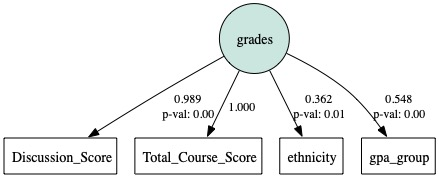

Model Name: Grades_CFA
Ideal RMSEA is <0.1, actual is 0.13
Ideal CFI is >0.9, actual is 0.95
Ideal GFI is >0.9, actual is 0.94
Ideal TLI is >0.95, actual is 0.86


In [24]:
latent_grades = '''
grades =~ Total_Course_Score + Discussion_Score + gpa_group + ethnicity
'''
run_SEM(data, latent_grades, 'Grades_CFA')

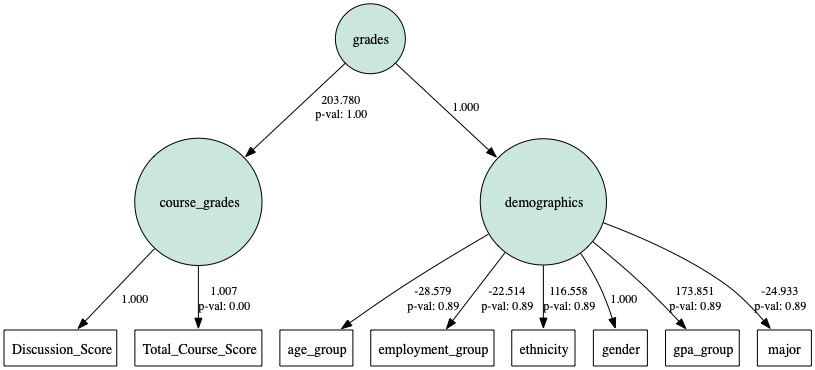

Model Name: all_demo
Ideal RMSEA is <0.1, actual is 0.09
Ideal CFI is >0.9, actual is 0.83
Ideal GFI is >0.9, actual is 0.78
Ideal TLI is >0.95, actual is 0.74


In [25]:
new_grade_cols = ['Discussion_Score', 'Total_Course_Score']
new_demographic_cols = ['gender', 'age_group', 'ethnicity', 'gpa_group', 'major', 'employment_group']

all_demographics = '''
demographics =~ gender + age_group + ethnicity + gpa_group + major + employment_group 
course_grades =~ Discussion_Score + Total_Course_Score
grades =~ demographics + course_grades
'''

run_SEM(data, all_demographics, 'all_demo')

## SEM for combined Presence, Cognitive Load, and Grades

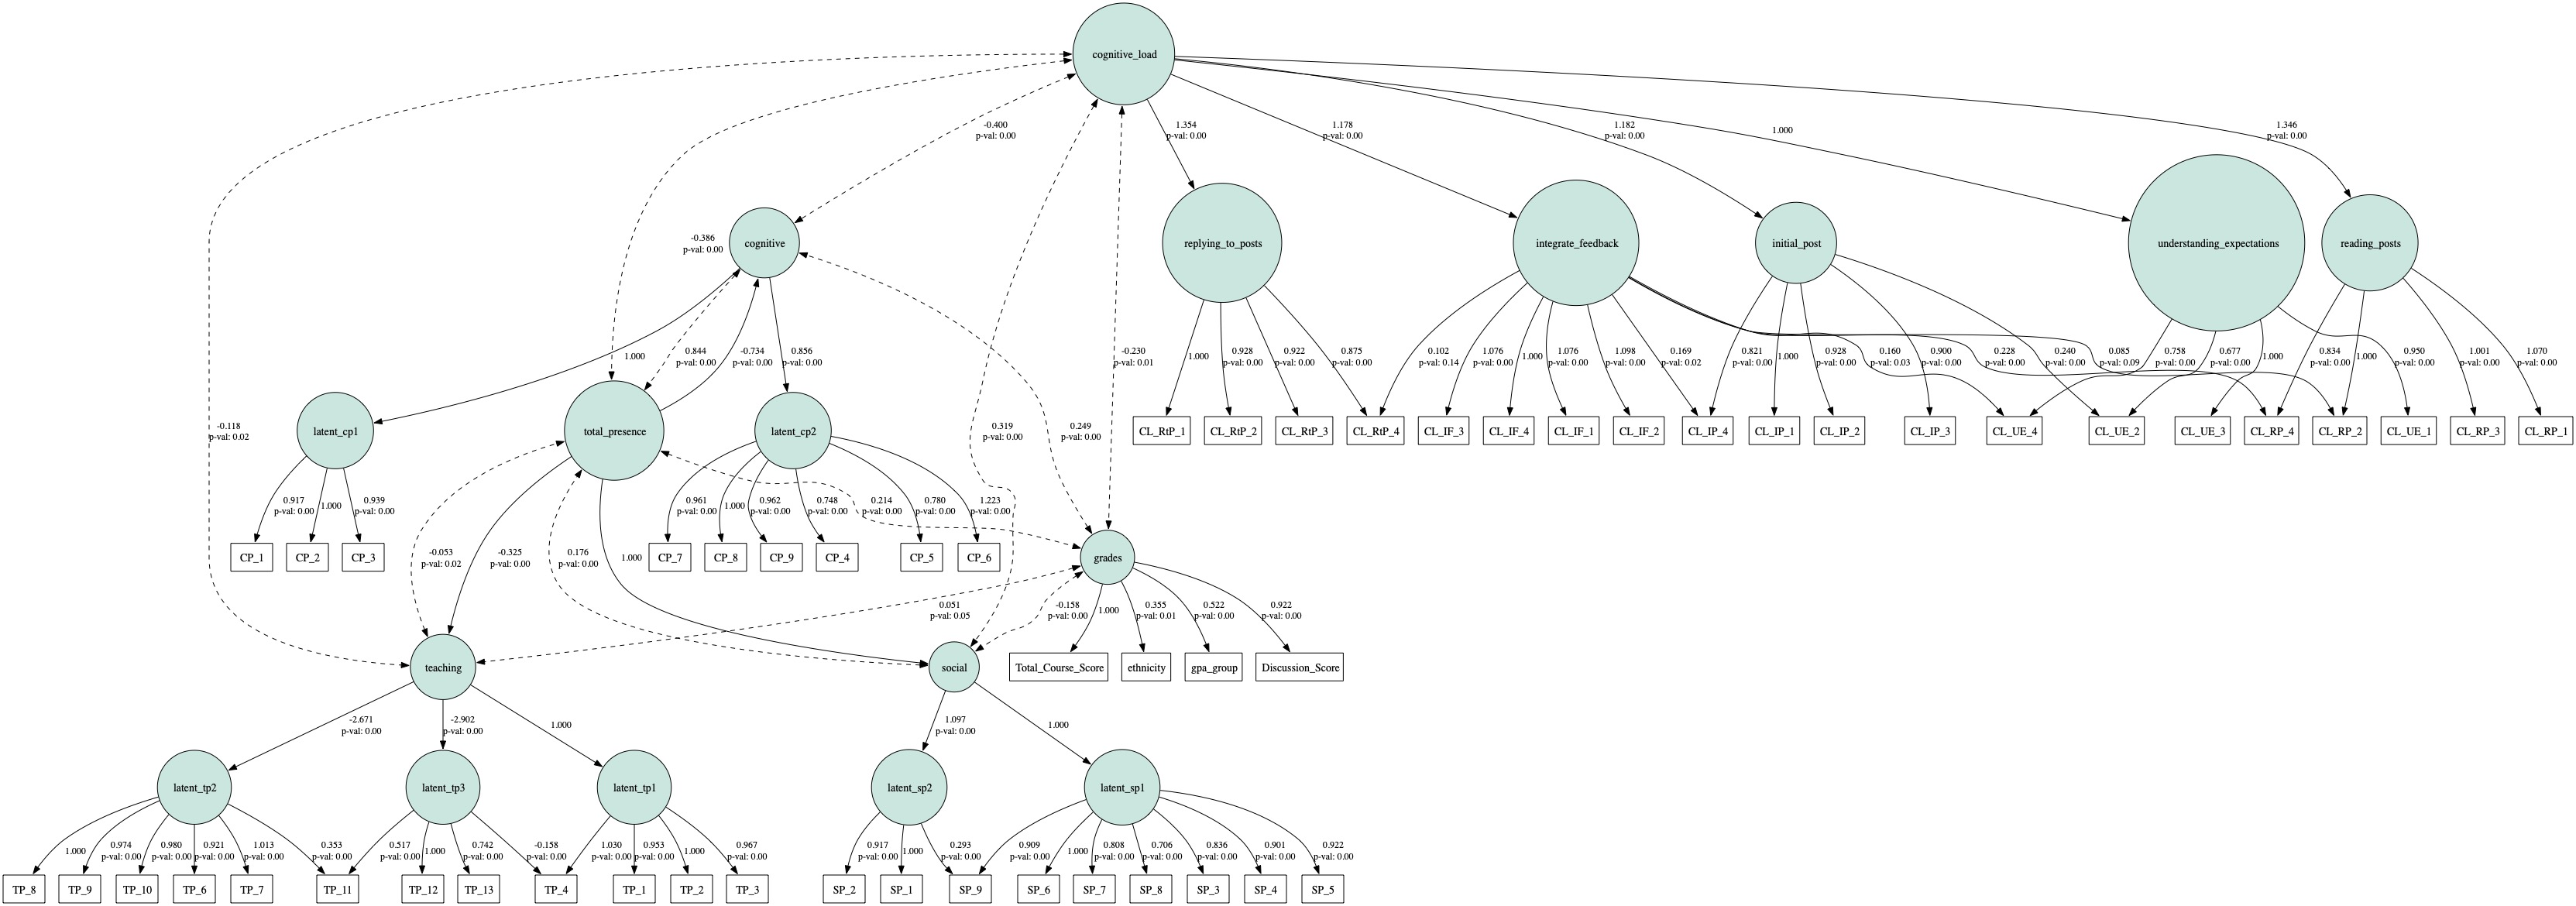

Model Name: Presence_Cog_Load_and_Grades
Ideal RMSEA is <0.1, actual is 0.07
Ideal CFI is >0.9, actual is 0.87
Ideal GFI is >0.9, actual is 0.79
Ideal TLI is >0.95, actual is 0.86


In [26]:
latent_teaching_efa = '''
latent_tp1 =~ TP_2 + TP_3 + TP_4 + TP_1
latent_tp2 =~ TP_8 + TP_10 + TP_7 + TP_9 + TP_6 + TP_11
latent_tp3 =~ TP_12 + TP_11 + TP_13 + TP_4
teaching =~ latent_tp1 + latent_tp2 + latent_tp3
'''

latent_social_efa = '''
latent_sp1 =~ SP_6 + SP_5 + SP_9 + SP_4 + SP_7 + SP_8 + SP_3
latent_sp2 =~ SP_1 + SP_2 + SP_9
social =~ latent_sp1 + latent_sp2
'''

latent_cognitive_efa = '''
latent_cp1 =~ CP_2 + CP_3 + CP_1
latent_cp2 =~ CP_8 + CP_7 + CP_6 + CP_9 + CP_5 + CP_4
cognitive =~ latent_cp1 + latent_cp2
'''

latent_relations_presence = '''
total_presence =~  social + cognitive + teaching
'''

latent_cognitive_load_efa = '''
replying_to_posts =~ CL_RtP_1 + CL_RtP_3 + CL_RtP_2 + CL_RtP_4
understanding_expectations =~ CL_UE_3 + CL_UE_1 + CL_UE_2 + CL_UE_4
integrate_feedback =~ CL_IF_4 + CL_RP_4 + CL_RP_2 + CL_IF_1 + CL_RtP_4 + CL_IP_4 + CL_UE_4
reading_posts =~ CL_RP_2 + CL_RP_1 + CL_RP_3 + CL_RP_4
integrate_feedback =~ CL_IF_2 + CL_IF_3 + CL_IF_1 + CL_IF_4
initial_post =~ CL_IP_1 + CL_IP_2 + CL_IP_3 + CL_UE_2 + CL_IP_4
cognitive_load =~ understanding_expectations + initial_post + reading_posts + replying_to_posts + integrate_feedback
'''

latent_grades = '''
grades =~ Total_Course_Score + Discussion_Score + gpa_group + ethnicity

grades ~~ total_presence
grades ~~ cognitive_load
teaching ~~ grades
cognitive ~~ grades
social ~~ grades

total_presence ~~ cognitive_load
teaching ~~ cognitive_load
cognitive ~~ cognitive_load
social ~~ cognitive_load

total_presence ~~ teaching
total_presence ~~ cognitive
total_presence ~~ social 
'''

description_presence_and_cog_load_efa = f'{latent_teaching_efa}\n{latent_social_efa}\n{latent_cognitive_efa}\n{latent_relations_presence}\n{latent_cognitive_load_efa}\n{latent_grades}'
run_SEM(data, description_presence_and_cog_load_efa, 'Presence_Cog_Load_and_Grades')

In [27]:
latent_tp = ['latent_tp1', 'latent_tp2', 'latent_tp3']
latent_sp = ['latent_sp1', 'latent_sp2']
latent_cp = ['latent_cp1', 'latent_cp2']
latent_cl = ['replying_to_posts', 'integrate_feedback', 'initial_post', 'understanding_expectations', 'reading_posts']

latent_data = data[latent_tp+latent_sp+latent_cp+latent_cl+new_demographic_cols+new_grade_cols].copy()
latent_data.dropna(how='any', inplace=True)
print(semopy.efa.explore_cfa_model(latent_data))

eta2 =~ latent_cp2 + latent_cp1 + latent_sp2 + latent_sp1



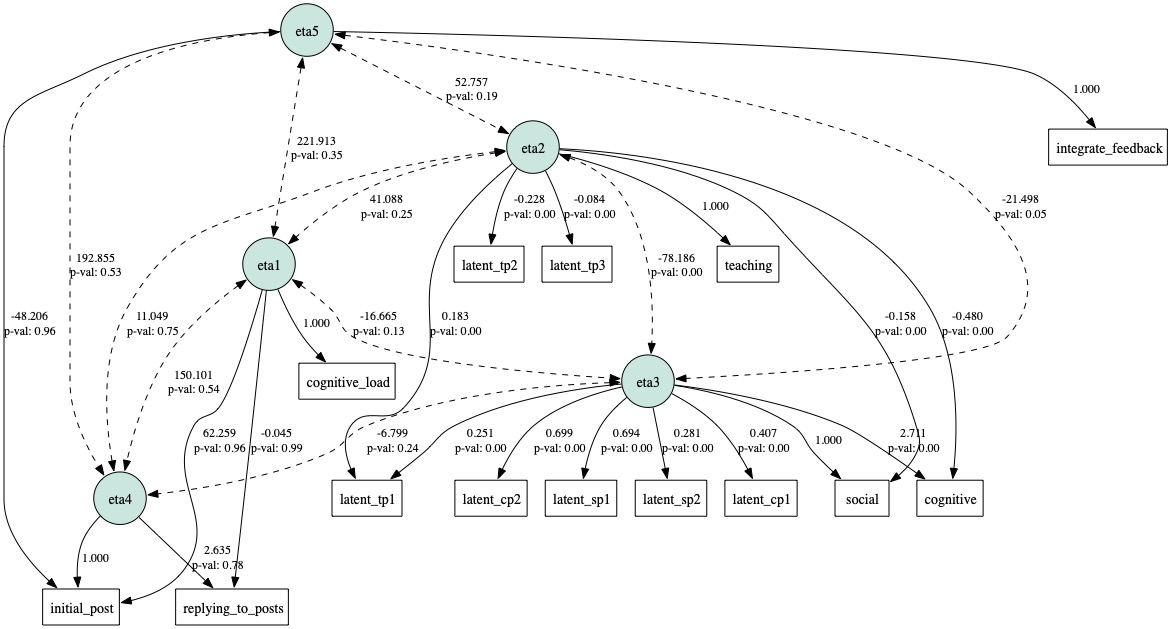

Model Name: Special
Ideal RMSEA is <0.1, actual is 0.38
Ideal CFI is >0.9, actual is 0.64
Ideal GFI is >0.9, actual is 0.64
Ideal TLI is >0.95, actual is 0.46


In [28]:
latent_description = '''
eta1 =~ cognitive_load + initial_post + replying_to_posts
eta2 =~ teaching + cognitive + social + latent_tp2 + latent_tp3 + latent_tp1
eta3 =~ social + cognitive + latent_cp2 + latent_sp1 + latent_sp2 + latent_cp1 + latent_tp1
eta4 =~ initial_post + replying_to_posts
eta5 =~ integrate_feedback + initial_post
'''

run_SEM(data, latent_description, 'Special')

In [29]:
big_picture_data = data[['teaching', 'social', 'cognitive', 'replying_to_posts', 'integrate_feedback', 'initial_post', 'understanding_expectations', 'reading_posts', 'cognitive_load', 'Discussion_Score', 'Total_Course_Score']].copy()
big_picture_data.dropna(how='any', inplace=True)
print(semopy.efa.explore_cfa_model(big_picture_data))

eta2 =~ cognitive + social + teaching
eta3 =~ integrate_feedback + reading_posts



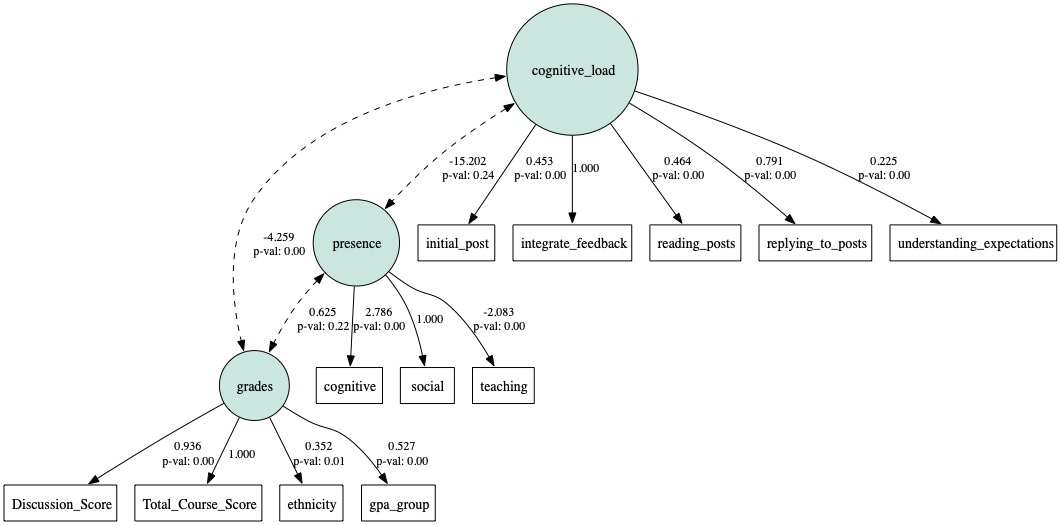

Model Name: Final_ALL
Ideal RMSEA is <0.1, actual is 0.15
Ideal CFI is >0.9, actual is 0.9
Ideal GFI is >0.9, actual is 0.88
Ideal TLI is >0.95, actual is 0.87


In [30]:
final_description = '''
cognitive_load =~ integrate_feedback + reading_posts + initial_post + replying_to_posts + understanding_expectations
presence =~ social + cognitive + teaching
grades =~ Total_Course_Score + Discussion_Score + gpa_group + ethnicity
'''

run_SEM(data, final_description, 'Final_ALL')

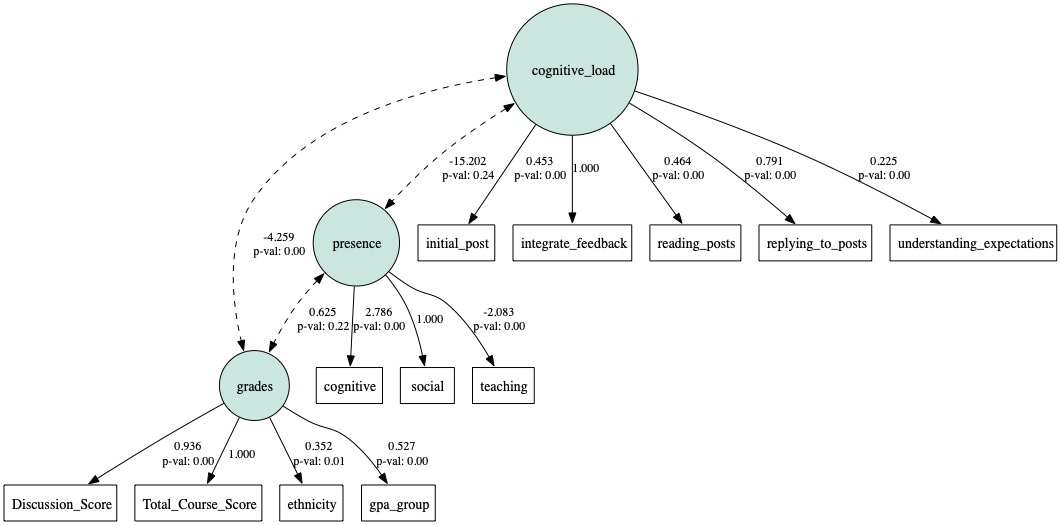

Model Name: Final_ALL
Ideal RMSEA is <0.1, actual is 0.15
Ideal CFI is >0.9, actual is 0.9
Ideal GFI is >0.9, actual is 0.88
Ideal TLI is >0.95, actual is 0.87


In [31]:
final_description = '''
cognitive_load =~ integrate_feedback + reading_posts + initial_post + replying_to_posts + understanding_expectations
presence =~ social + cognitive + teaching
grades =~ Total_Course_Score + Discussion_Score + gpa_group + ethnicity
'''

run_SEM(data, final_description, 'Final_ALL')

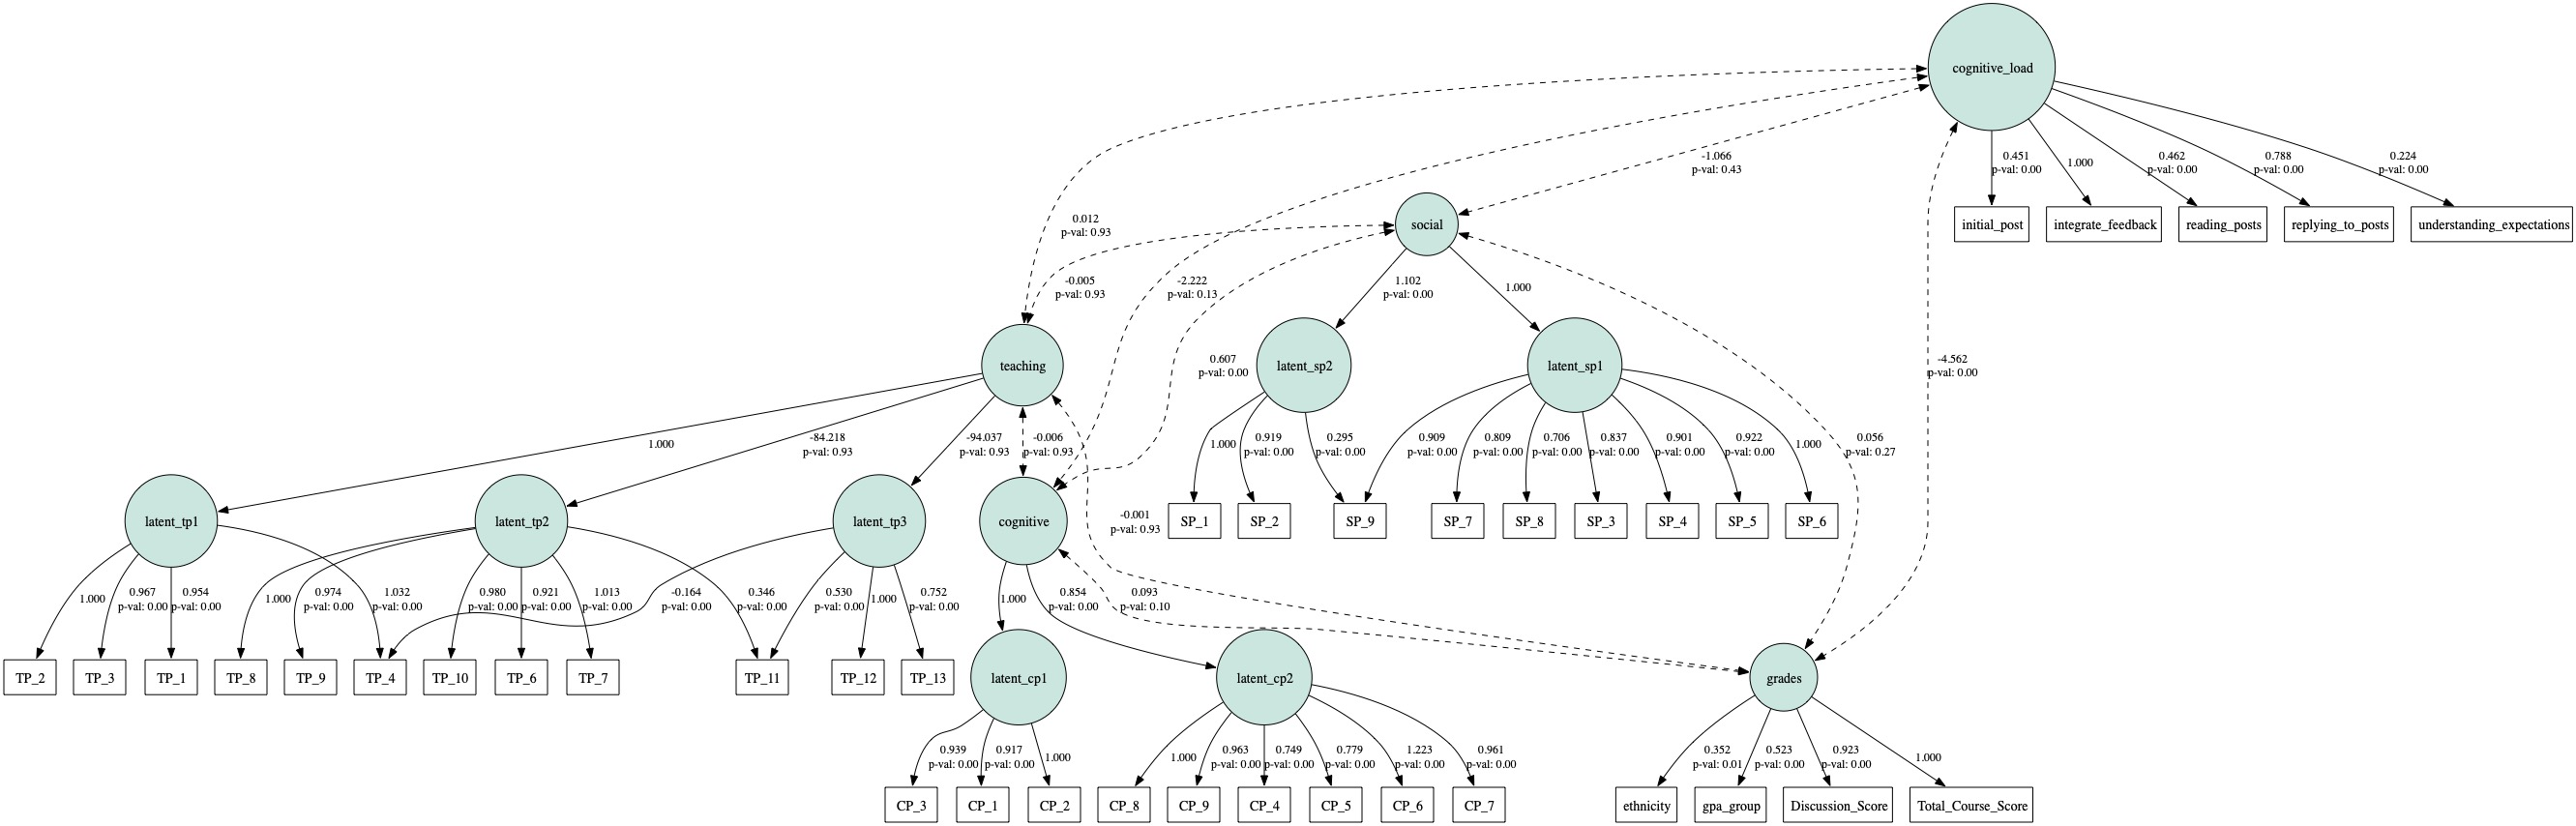

Model Name: Final_Alt_ALL
Ideal RMSEA is <0.1, actual is 0.08
Ideal CFI is >0.9, actual is 0.9
Ideal GFI is >0.9, actual is 0.84
Ideal TLI is >0.95, actual is 0.89


In [32]:
final_alt_description = '''
cognitive_load =~ integrate_feedback + reading_posts + initial_post + replying_to_posts + understanding_expectations
grades =~ Total_Course_Score + Discussion_Score + gpa_group + ethnicity

latent_tp1 =~ TP_2 + TP_3 + TP_4 + TP_1
latent_tp2 =~ TP_8 + TP_10 + TP_7 + TP_9 + TP_6 + TP_11
latent_tp3 =~ TP_12 + TP_11 + TP_13 + TP_4
teaching =~ latent_tp1 + latent_tp2 + latent_tp3

latent_sp1 =~ SP_6 + SP_5 + SP_9 + SP_4 + SP_7 + SP_8 + SP_3
latent_sp2 =~ SP_1 + SP_2 + SP_9
social =~ latent_sp1 + latent_sp2

latent_cp1 =~ CP_2 + CP_3 + CP_1
latent_cp2 =~ CP_8 + CP_7 + CP_6 + CP_9 + CP_5 + CP_4
cognitive =~ latent_cp1 + latent_cp2

'''

run_SEM(data, final_alt_description, 'Final_Alt_ALL')

# Aggregate Statistics for Pre-Post evaluation

In [33]:
print(data.columns)

Index(['Speaker ID', 'PRE or POST', 'Survey Month', 'Survey Year',
       'Course Term', 'Course Year', 'Cohort', 'Class ID', 'Discussion_Score',
       'Total_Course_Score', 'gender', 'age_group', 'ethnicity', 'gpa_group',
       'major', 'employment_group', 'CL_UE_1', 'CL_UE_2', 'CL_UE_3', 'CL_UE_4',
       'CL_IP_1', 'CL_IP_2', 'CL_IP_3', 'CL_IP_4', 'CL_RP_1', 'CL_RP_2',
       'CL_RP_3', 'CL_RP_4', 'CL_RtP_1', 'CL_RtP_2', 'CL_RtP_3', 'CL_RtP_4',
       'CL_IF_1', 'CL_IF_2', 'CL_IF_3', 'CL_IF_4', 'TP_1', 'TP_2', 'TP_3',
       'TP_4', 'TP_6', 'TP_7', 'TP_8', 'TP_9', 'TP_10', 'TP_11', 'TP_12',
       'TP_13', 'SP_1', 'SP_2', 'SP_3', 'SP_4', 'SP_5', 'SP_6', 'SP_7', 'SP_8',
       'SP_9', 'CP_1', 'CP_2', 'CP_3', 'CP_4', 'CP_5', 'CP_6', 'CP_7', 'CP_8',
       'CP_9', 'CP_10', 'CP_11', 'CP_12', 'latent_tp1', 'latent_tp3',
       'latent_tp2', 'latent_sp1', 'latent_sp2', 'latent_cp1', 'latent_cp2',
       'teaching', 'cognitive', 'social', 'understanding_expectations',
       'initial_pos

In [34]:
intermediate_CoI_latent = ['teaching', 'social', 'cognitive']
intermediate_CL_latent = ['replying_to_posts', 'integrate_feedback', 'understanding_expectations', 'initial_post', 'reading_posts', 'cognitive_load']

for CoI_latent in intermediate_CoI_latent:
    data[CoI_latent] = stats.zscore(data[CoI_latent], nan_policy='omit')

for CL_latent in intermediate_CL_latent:
    data[CL_latent] = stats.zscore(data[CL_latent], nan_policy='omit')

print(data[intermediate_CL_latent].describe)

pre_data = data[data['PRE or POST'] == 'PRE'].copy()
pre_data = pre_data.replace(replace_dict)

post_data = data[data['PRE or POST'] == 'POST'].copy()
post_data = post_data.replace(replace_dict)

for dict in [teaching_presence_dict, social_presence_dict, cognitive_presence_dict, understanding_expectations_dict, initial_post_dict, reading_posts_dict, replying_to_posts_dict, integrate_feedback_dict, grade_dict, demographic_dict]:
    pre_data.rename(dict, axis='columns', inplace=True)
    post_data.rename(dict, axis='columns', inplace=True)

<bound method NDFrame.describe of      replying_to_posts  integrate_feedback  understanding_expectations   
0             0.236002            0.710606                    0.304504  \
1             0.236002            0.710606                    0.304504   
2             2.598606            2.728810                    0.403873   
3             2.598606            2.728810                    0.403873   
4             0.865948            0.989537                    0.739767   
..                 ...                 ...                         ...   
270           0.015377            0.161332                    0.682351   
272           0.750823            0.889175                    0.791942   
273           0.750823            0.889175                    0.791942   
274           0.098378           -0.432388                    0.522485   
276           0.199865            0.242538                    0.644105   

     initial_post  reading_posts  cognitive_load  
0        0.254307       0.

In [35]:
# Define latent values pre_data
#pre_CoI_coeff_df, pre_CoI_err_df = extract_estimates(f'{base_dir}{path_break}Estimates{path_break}inspect_estimates_PRE_Full_Model.xlsx')
#apply_estimates(pre_data, pre_CoI_coeff_df, pre_CoI_err_df)

#pre_CL_coeff_df, pre_CL_err_df = extract_estimates(f'{base_dir}{path_break}Estimates{path_break}inspect_estimates_PRE_Full_Model.xlsx')
#apply_estimates(pre_data, pre_CL_coeff_df, pre_CL_err_df)

# Define latent values post_data
#post_CoI_coeff_df, post_CoI_err_df = extract_estimates(f'{base_dir}{path_break}Estimates{path_break}inspect_estimates_POST_Full_Model.xlsx')
#apply_estimates(post_data, post_CoI_coeff_df, post_CoI_err_df)

#post_CL_coeff_df, post_CL_err_df = extract_estimates(f'{base_dir}{path_break}Estimates{path_break}inspect_estimates_POST_Full_Model.xlsx')
#apply_estimates(post_data, post_CL_coeff_df, post_CL_err_df)

In [36]:
list_of_dicts = []

for latent in intermediate_CoI_latent + intermediate_CL_latent:
    latent_pre = np.array(pre_data[latent])
    latent_post = np.array(post_data[latent])
    results = stats.ttest_ind(a=latent_pre, b=latent_post, equal_var = False)
    temp_dict = {
        'Latent': latent, 
        'Pre-Intervention Mean': round(latent_pre.mean(), 3),
        'Post-Intervention Mean': round(latent_post.mean(), 3),
        'Mean Difference': round(latent_post.mean() - latent_pre.mean(), 3), 
        'Test Statistic': round(results[0], 3), 
        'p-value': round(results[1], 3)
    }
    list_of_dicts.append(temp_dict)

t_test_df = pd.DataFrame(list_of_dicts)

In [37]:
t_test_df.to_excel('t-test_results.xlsx')

In [38]:
pre_data[intermediate_CoI_latent].describe()

teaching      social   cognitive
count  161.000000  161.000000  161.000000
mean    -0.002433   -0.070937   -0.054599
std      1.039242    1.105571    1.086432
min     -1.248281   -2.998556   -2.940371
25%     -0.953522   -0.926190   -0.818119
50%     -0.119409    0.139976    0.045249
75%      0.720450    0.910295    0.888460
max      3.267206    1.478223    1.413507

In [39]:
post_data[intermediate_CoI_latent].describe()

teaching     social  cognitive
count  89.000000  89.000000  89.000000
mean    0.004401   0.128325   0.098769
std     0.936589   0.769875   0.824335
min    -1.248281  -1.717793  -2.395534
25%    -0.783636  -0.324804  -0.332762
50%    -0.119409   0.155836   0.161617
75%     0.626397   0.616432   0.802835
max     2.568585   1.478223   1.413507

In [40]:
pre_data[intermediate_CL_latent].describe()

replying_to_posts  integrate_feedback  understanding_expectations   
count         161.000000          161.000000                  161.000000  \
mean           -0.070185           -0.049238                   -0.026066   
std             1.026427            1.027142                    1.013320   
min            -2.279326           -2.123412                   -2.091031   
25%            -0.844506           -0.823701                   -0.629343   
50%            -0.136828           -0.058240                   -0.003457   
75%             0.694875            0.636065                    0.720690   
max             2.778591            3.003513                    1.970078   

       initial_post  reading_posts  cognitive_load  
count    161.000000     161.000000      161.000000  
mean      -0.015213      -0.062966       -0.046856  
std        1.040740       1.015903        1.021828  
min       -2.403703      -2.081204       -2.385268  
25%       -0.778358      -0.898255       -0.726555  
50%       -0.070570      -0.028820       -0.007134  
75%        0.700241       0.702213        0.654759  
max        2.358917       2.659839        2.585887

In [41]:
post_data[intermediate_CL_latent].describe()

replying_to_posts  integrate_feedback  understanding_expectations   
count          89.000000           89.000000                   89.000000  \
mean            0.126963            0.089072                    0.047152   
std             0.948706            0.954059                    0.985128   
min            -2.048665           -1.951445                   -2.091031   
25%            -0.448047           -0.481070                   -0.450491   
50%             0.121118            0.243113                    0.172754   
75%             0.534061            0.606272                    0.779821   
max             2.559988            2.571141                    2.215384   

       initial_post  reading_posts  cognitive_load  
count     89.000000      89.000000       89.000000  
mean       0.027520       0.113904        0.084762  
std        0.932938       0.971630        0.964989  
min       -2.103419      -1.903605       -2.118215  
25%       -0.489413      -0.473093       -0.532928  
50%        0.022024       0.112015        0.067867  
75%        0.713995       0.696545        0.777813  
max        2.558104       2.301995        2.422571